In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import multiprocessing
import jax
from cohlib.jax.utils import add0
import jax.random as jr
# from cohlib.jax.utils import jax_boilerplate
# jax_boilerplate()

os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={multiprocessing.cpu_count()}"
# os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={10}"
jax.config.update('jax_platform_name', 'cpu')
platform = jax.lib.xla_bridge.get_backend().platform.casefold()
print("Platform: ", platform)
print(len(jax.devices()))

Platform:  cpu
28


In [3]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

from cohlib.utils import pickle_open
from cohlib.confs.utils import omega

from cohlib.jax.lr_model import rotate_eigvecs
from cohlib.jax.dists import naive_estimator
import cohlib.confs.utils as conf

In [97]:
gamma_seed = 0
def temp_func(K, L, seed, mu, rankname='rank1', gamma_seed=0):
    latent_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rankname}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/latent_sim.pkl'

    latent_load = pickle_open(latent_path)
    return latent_load['lcfg']


def get_sim_gamma_ests(K, L, seed, mu, rankname='rank1', gamma_seed=0):
    obs_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rankname}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/obs_sim.pkl'
    latent_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rankname}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/latent_sim.pkl'

    obs_load = pickle_open(obs_path)
    latent_load = pickle_open(latent_path)

    obs = obs_load['obs']
    zs_nz = latent_load['zs_nz']

    lcfg = conf.omega(latent_load['lcfg'])
    if rankname == 'rank1': 
        ccn_true = conf.create_lrccn_basic_rank1(lcfg, print_seed=False)
    elif rankname == 'fullrank':
        ccn_true = conf.create_ccn_basic_fullrank(lcfg, print_seed=False)
    else:
        raise ValueError
    # gamma_true = lrccn_true.get_gamma()
    nz_model = jnp.array([lcfg.target_freq_ind])

    naive_est = naive_estimator(obs, nz_model)*1e6
    oracle_est = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)

    return ccn_true, naive_est, oracle_est

def get_sim_ests(K, L, seed, mu, rankname='rank1', gamma_seed=0):
    obs_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rankname}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/obs_sim.pkl'
    latent_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rankname}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/latent_sim.pkl'

    obs_load = pickle_open(obs_path)
    latent_load = pickle_open(latent_path)

    obs = obs_load['obs']
    zs_nz = latent_load['zs_nz']

    lcfg = conf.omega(latent_load['lcfg'])
    lrccn_true = conf.create_lrccn_basic_rank1(lcfg, print_seed=False)
    # gamma_true = lrccn_true.get_gamma()
    nz_model = jnp.array([lcfg.target_freq_ind])

    naive_est = naive_estimator(obs, nz_model)*1e6
    eigvals_naive_raw, eigvecs_naive_raw = jnp.linalg.eigh(naive_est)
    eigvals_naive = eigvals_naive_raw[:,::-1]
    eigvecs_naive = eigvecs_naive_raw[:,:,::-1]

    oracle_est = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
    eigvals_oracle_raw, eigvecs_oracle_raw = jnp.linalg.eigh(oracle_est)
    eigvals_oracle = eigvals_oracle_raw[:,::-1]
    eigvecs_oracle = eigvecs_oracle_raw[:,:,::-1]

    return lrccn_true, eigvals_naive, eigvecs_naive, eigvals_oracle, eigvecs_oracle


def get_fullrank_model_ests(K, L, seed, mu, init, rankname='rank1', gamma_seed=0):
    if init == 'flat':
        res_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rankname}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/model-simple_inherit_latent_fullrank/inherit-True/m_step-full-rank-standard/{init}-init_6.0/newton-10_em-20/res.pkl'
    if init == 'empirical':
        res_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rankname}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/model-simple_inherit_latent_fullrank/inherit-True/m_step-full-rank-standard/{init}-init/newton-10_em-20/res.pkl'

    res_load = pickle_open(res_path)

    eigvals = get_eigvals(res_load['ccn_est'])
    eigvecs = get_eigvecs(res_load['ccn_est'])
    return eigvals, eigvecs

def get_lowrank_model_ests(K, L, seed, mu, init, rankname='rank1', gamma_seed=0):
    if init == 'flat':
        res_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rankname}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/model-simple_inherit_latent_lowrank_eigh/inherit-True/m_step-low-rank-eigh/{init}-init_6.0_eigvals-fit_eigvecs-fit/newton-10_em-20/res.pkl'
    if init == 'empirical':
        res_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rankname}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/model-simple_inherit_latent_lowrank_eigh/inherit-True/m_step-low-rank-eigh/{init}-init_eigvals-fit_eigvecs-fit/newton-10_em-20/res.pkl'

    res_load = pickle_open(res_path)
    lrccn_est = res_load['lrccn_est'] 
    return lrccn_est.eigvals, lrccn_est.eigvecs

    # eigvals = get_eigvals(res_load['ccn_est'])
    # eigvecs = get_eigvecs(res_load['ccn_est'])
    # return eigvals, eigvecs

In [33]:
def get_eigvecs(ccn):
    """
    ccn.gamma shape (J x K x K)
    """
    gamma = ccn.gamma
    _, eigvecs_raw = jnp.linalg.eigh(gamma)
    eigvecs = eigvecs_raw[:,:,::-1]
    return eigvecs

def get_eigvals(ccn):
    """
    ccn.gamma shape (J x K x K)
    """
    gamma = ccn.gamma
    eigvals_raw, _ = jnp.linalg.eigh(gamma)
    eigvals = eigvals_raw[:,::-1]
    return eigvals


In [34]:
K = 3
L = 5
seed = 0
mu = 0.0
lrccn_true, eigvals_naive, eigvecs_naive, eigvals_oracle, eigvecs_oracle = get_sim_ests(K, L, seed, mu)
lrccn_true, gamma_naive, gamma_oracle = get_sim_gamma_ests(K, L, seed, mu)
gamma_true = lrccn_true.get_gamma()

Creating equal magnitude eigenvector with random phases (gamma seed: 1)


(-10000000.0, 10000000.0)

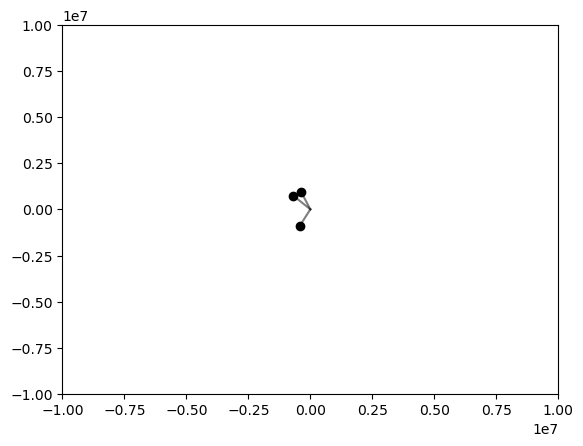

In [35]:
j = 0
lcfg = omega(temp_func(K, L, seed, mu))
lcfg.gamma_seed = 1
lrccn = conf.create_lrccn_basic_rank1(lcfg)
gamma_true = lrccn.get_gamma()
fig, ax = plt.subplots()
pairs = [(0,1), (0,2), (1,2)]
for u, v in pairs:
    ax.scatter(jnp.real(gamma_true[j,u,v]), jnp.imag(gamma_true[j,u,v]), color='k')
    ax.plot([0, jnp.real(gamma_true[j,u,v])], [0, jnp.imag(gamma_true[j,u,v])], 'k', alpha=0.5)
ax.set_xlim(-1e7, 1e7)
ax.set_ylim(-1e7, 1e7)

In [36]:
print(jnp.real(lrccn_true.get_gamma()))
print(jnp.real(gamma_oracle))
print(jnp.real(gamma_naive))

[[[ 999999.94 -584528.25 -494320.22]
  [-584528.25 1000000.   -416366.4 ]
  [-494320.22 -416366.34 1000000.  ]]]
[[[ 945230.3  -552513.9  -467246.5 ]
  [-552513.9   945230.44 -393562.12]
  [-467246.5  -393562.12  945230.3 ]]]
[[[ 8396732.  -2677120.5 -3306995.8]
  [-2677120.5  8810762.  -3457753. ]
  [-3306995.8 -3457753.   5145548. ]]]


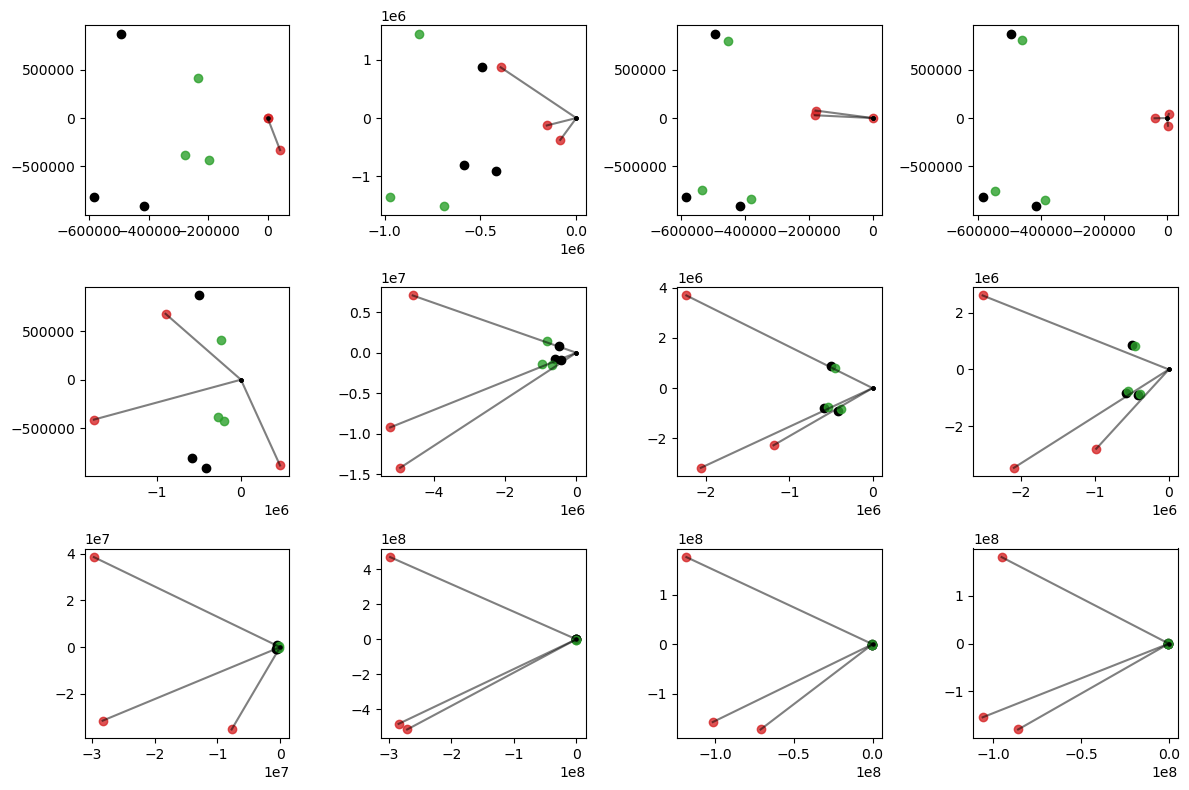

In [38]:
j = 0
mus = jnp.array([-2.0, 0.0, 2.0])
Ls = jnp.array([3, 5, 10, 25])
pairs = [(0,1), (0,2), (1,2)]

seed = 3
fig, axs = plt.subplots(mus.size, Ls.size, figsize = (12,8))
for m, mu in enumerate(mus):
    for ell, L in enumerate(Ls):
        lrccn_true, eigvals_naive, eigvecs_naive, eigvals_oracle, eigvecs_oracle = get_sim_ests(K, L, seed, mu)
        lrccn_true, gamma_naive, gamma_oracle = get_sim_gamma_ests(K, L, seed, mu)
        gamma_true = lrccn_true.get_gamma()
        ax = axs[m,ell]
        for u, v in pairs:
            ax.scatter(jnp.real(gamma_true[j,u,v]), jnp.imag(gamma_true[j,u,v]), color='k')
            ax.scatter(jnp.real(gamma_oracle[j,u,v]), jnp.imag(gamma_oracle[j,u,v]), color='tab:green', alpha=0.8)
            ax.scatter(jnp.real(gamma_naive[j,u,v]), jnp.imag(gamma_naive[j,u,v]), color='tab:red', alpha=0.8)
            ax.plot([0, jnp.real(gamma_naive[j,u,v])], [0, jnp.imag(gamma_naive[j,u,v])], 'k', alpha=0.5)
            ax.scatter(0,0, s=5, color='k')

plt.tight_layout()



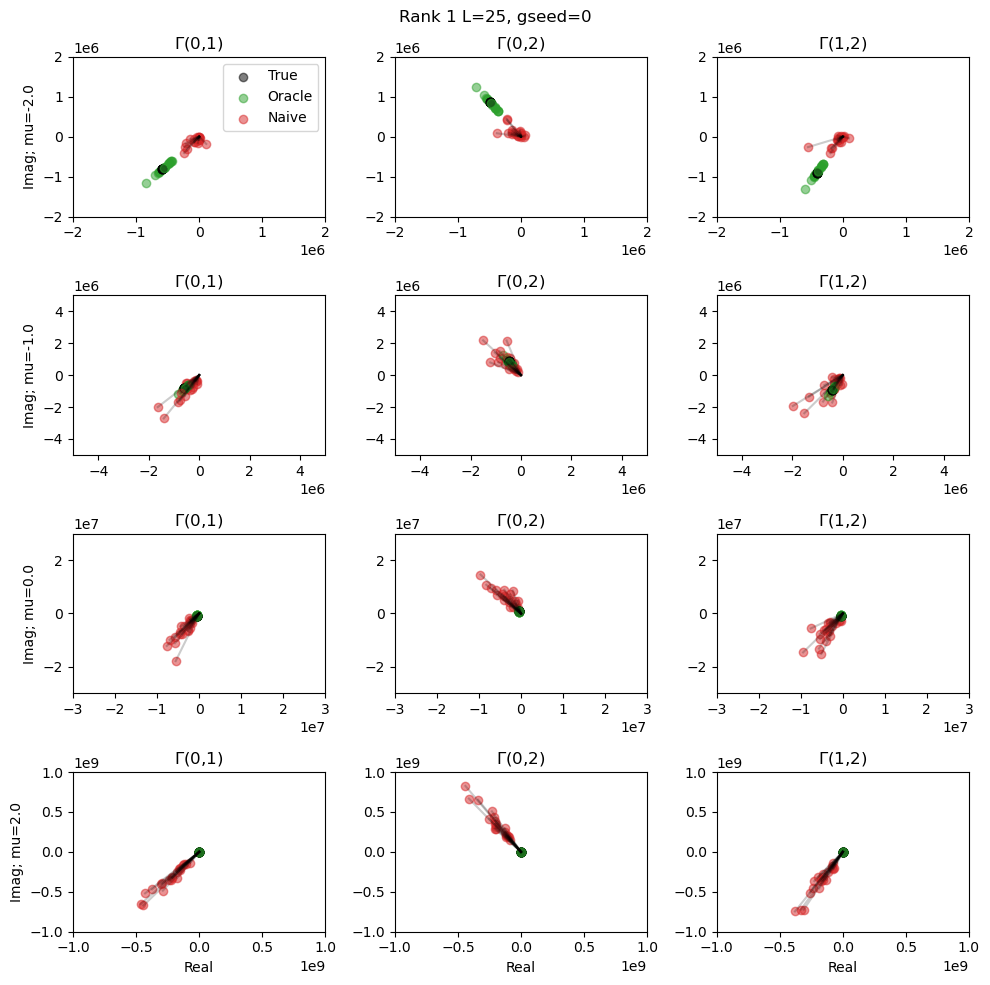

In [93]:
gamma_seed = 0
L = 25
# fig, axs = plt.subplots(mus.size, Ls.size, figsize = (12,8))
seeds = jnp.arange(20)
# fig, ax = plt.subplots()
pairs = [(0,1), (0,2), (1,2)]
lims = [2e6, 5e6, 3e7, 1e9]
fig, axs = plt.subplots(4,3,figsize=(10,10))
for m, mu in enumerate([-2.0, -1.0, 0.0, 2.0]):
    lim = lims[m]
    for i, (u, v) in enumerate(pairs):
        ax = axs[m,i]
        for seed in seeds:
            # lrccn_true, eigvals_naive, eigvecs_naive, eigvals_oracle, eigvecs_oracle = get_sim_ests(K, L, seed, mu, gamma_seed=gamma_seed)
            lrccn_true, gamma_naive, gamma_oracle = get_sim_gamma_ests(K, L, seed, mu, gamma_seed=gamma_seed)
            gamma_true = lrccn_true.get_gamma()

            if m == 0 and i == 0 and seed == 0:
                ax.scatter(jnp.real(gamma_true[j,u,v]), jnp.imag(gamma_true[j,u,v]), color='k', alpha=0.5, label='True')
                ax.scatter(jnp.real(gamma_oracle[j,u,v]), jnp.imag(gamma_oracle[j,u,v]), color='tab:green', alpha=0.5, label='Oracle')
                ax.scatter(jnp.real(gamma_naive[j,u,v]), jnp.imag(gamma_naive[j,u,v]), color='tab:red', alpha=0.5, label='Naive')
                ax.legend()
            else:
                ax.scatter(jnp.real(gamma_true[j,u,v]), jnp.imag(gamma_true[j,u,v]), color='k', alpha=0.5)
                ax.scatter(jnp.real(gamma_oracle[j,u,v]), jnp.imag(gamma_oracle[j,u,v]), color='tab:green', alpha=0.5)
                ax.scatter(jnp.real(gamma_naive[j,u,v]), jnp.imag(gamma_naive[j,u,v]), color='tab:red', alpha=0.5)
            ax.plot([0, jnp.real(gamma_naive[j,u,v])], [0, jnp.imag(gamma_naive[j,u,v])], 'k', alpha=0.2)
            ax.set_xlim(-lim, lim)
            ax.set_ylim(-lim, lim)
            ax.set_title(r'$\Gamma$' + f'({u},{v})' )
            if i == 0:
                ax.set_ylabel(f'Imag; mu={mu}')
            if m == 3:
                ax.set_xlabel('Real')
    fig.suptitle(f'Rank 1 L={L}, gseed={gamma_seed}')
            # ax.scatter(0,0, s=5, color='k', alpha=0.5)
    plt.tight_layout()

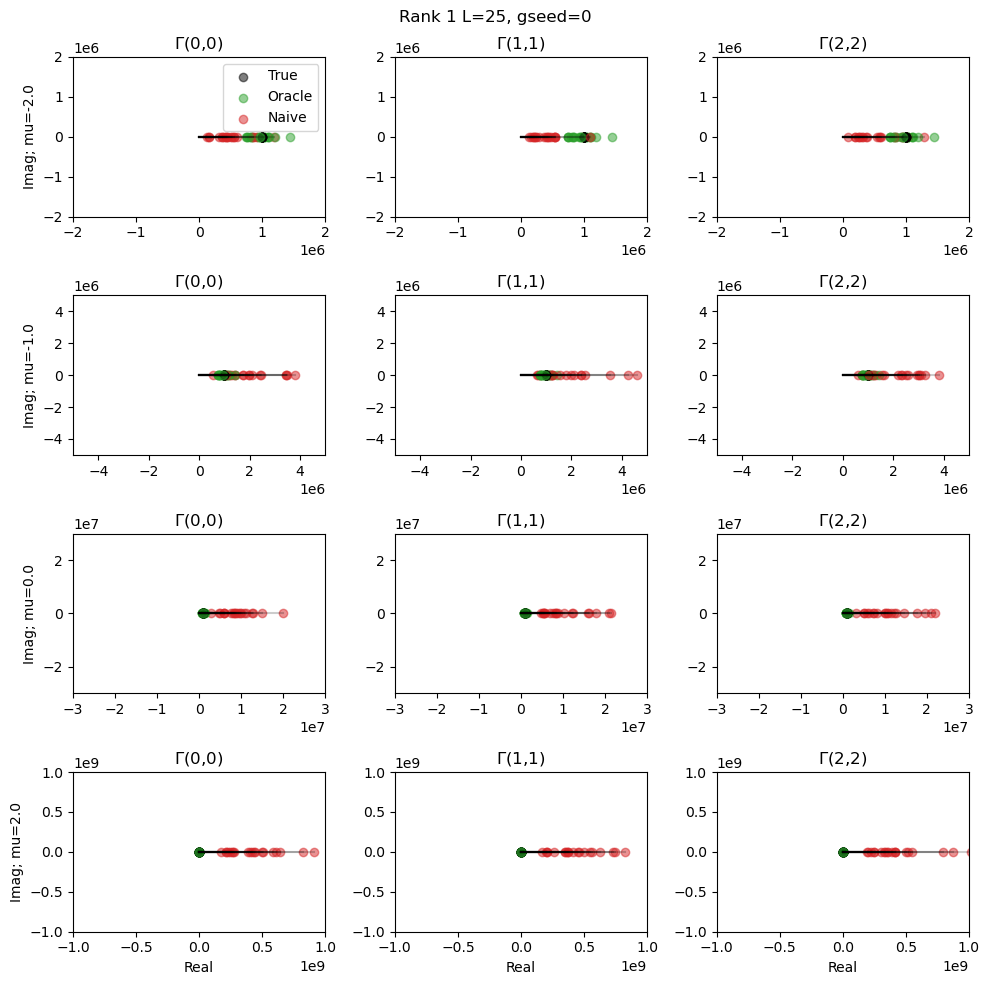

In [94]:
# fig, ax = plt.subplots()
lims = [2e6, 5e6, 3e7, 1e9]
pairs = [(0,0), (1,1), (2,2)]
fig, axs = plt.subplots(4,3,figsize=(10,10))
for m, mu in enumerate([-2.0, -1.0, 0.0, 2.0]):
    lim = lims[m]
    for i, (u, v) in enumerate(pairs):
        ax = axs[m,i]
        for seed in seeds:
            # lrccn_true, eigvals_naive, eigvecs_naive, eigvals_oracle, eigvecs_oracle = get_sim_ests(K, L, seed, mu, gamma_seed=gamma_seed)
            lrccn_true, gamma_naive, gamma_oracle = get_sim_gamma_ests(K, L, seed, mu, gamma_seed=gamma_seed)
            gamma_true = lrccn_true.get_gamma()

            if m == 0 and i == 0 and seed == 0:
                ax.scatter(jnp.real(gamma_true[j,u,v]), jnp.imag(gamma_true[j,u,v]), color='k', alpha=0.5, label='True')
                ax.scatter(jnp.real(gamma_oracle[j,u,v]), jnp.imag(gamma_oracle[j,u,v]), color='tab:green', alpha=0.5, label='Oracle')
                ax.scatter(jnp.real(gamma_naive[j,u,v]), jnp.imag(gamma_naive[j,u,v]), color='tab:red', alpha=0.5, label='Naive')
                ax.legend()
            else:
                ax.scatter(jnp.real(gamma_true[j,u,v]), jnp.imag(gamma_true[j,u,v]), color='k', alpha=0.5)
                ax.scatter(jnp.real(gamma_oracle[j,u,v]), jnp.imag(gamma_oracle[j,u,v]), color='tab:green', alpha=0.5)
                ax.scatter(jnp.real(gamma_naive[j,u,v]), jnp.imag(gamma_naive[j,u,v]), color='tab:red', alpha=0.5)
            ax.plot([0, jnp.real(gamma_naive[j,u,v])], [0, jnp.imag(gamma_naive[j,u,v])], 'k', alpha=0.2)
            ax.set_xlim(-lim, lim)
            ax.set_ylim(-lim, lim)
            ax.set_title(r'$\Gamma$' + f'({u},{v})' )
            if i == 0:
                ax.set_ylabel(f'Imag; mu={mu}')
            if m == 3:
                ax.set_xlabel('Real')
    fig.suptitle(f'Rank 1 L={L}, gseed={gamma_seed}')
            # ax.scatter(0,0, s=5, color='k', alpha=0.5)
    plt.tight_layout()

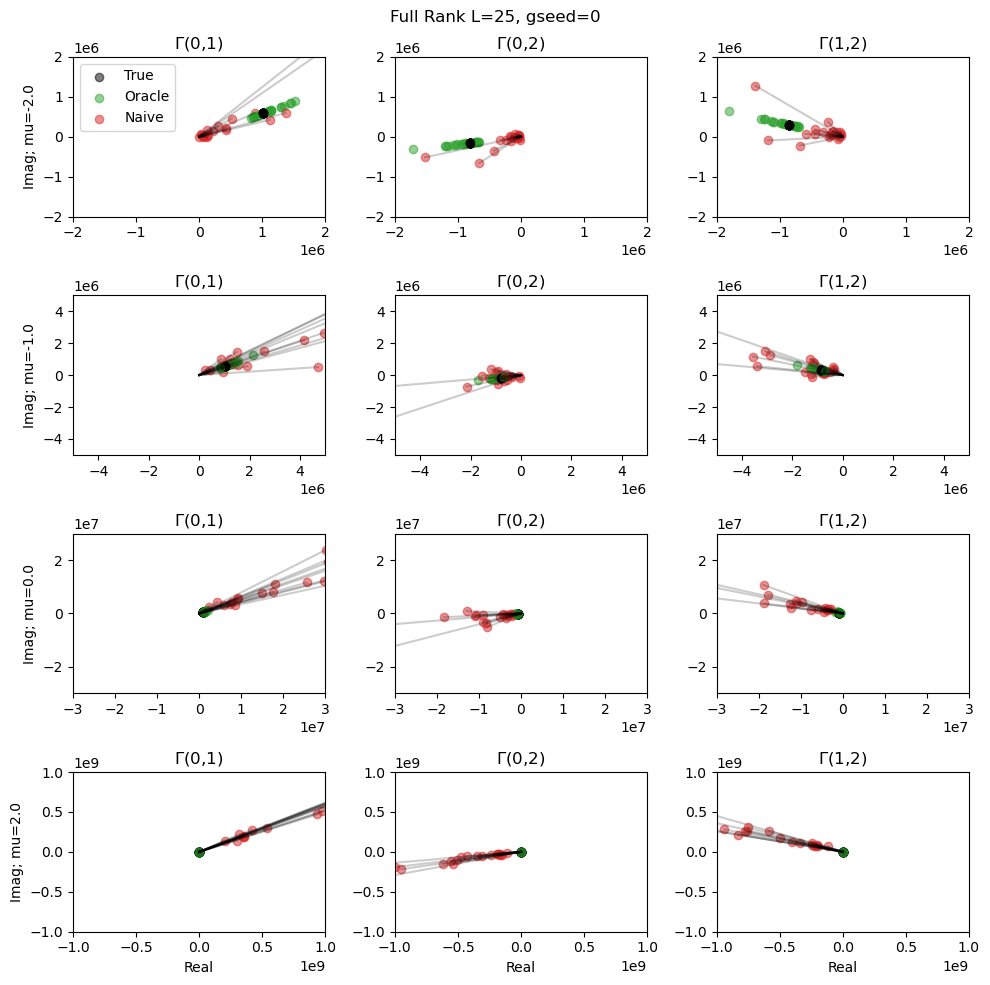

In [100]:
gamma_seed = 0
L = 25
# fig, axs = plt.subplots(mus.size, Ls.size, figsize = (12,8))
seeds = jnp.arange(20)
# fig, ax = plt.subplots()
pairs = [(0,1), (0,2), (1,2)]
lims = [2e6, 5e6, 3e7, 1e9]
fig, axs = plt.subplots(4,3,figsize=(10,10))
for m, mu in enumerate([-2.0, -1.0, 0.0, 2.0]):
    lim = lims[m]
    for i, (u, v) in enumerate(pairs):
        ax = axs[m,i]
        for seed in seeds:
            ccn_true, gamma_naive, gamma_oracle = get_sim_gamma_ests(K, L, seed, mu, gamma_seed=gamma_seed, rankname='fullrank')
            gamma_true = ccn_true.get_gamma()

            if m == 0 and i == 0 and seed == 0:
                ax.scatter(jnp.real(gamma_true[j,u,v]), jnp.imag(gamma_true[j,u,v]), color='k', alpha=0.5, label='True')
                ax.scatter(jnp.real(gamma_oracle[j,u,v]), jnp.imag(gamma_oracle[j,u,v]), color='tab:green', alpha=0.5, label='Oracle')
                ax.scatter(jnp.real(gamma_naive[j,u,v]), jnp.imag(gamma_naive[j,u,v]), color='tab:red', alpha=0.5, label='Naive')
                ax.legend()
            else:
                ax.scatter(jnp.real(gamma_true[j,u,v]), jnp.imag(gamma_true[j,u,v]), color='k', alpha=0.5)
                ax.scatter(jnp.real(gamma_oracle[j,u,v]), jnp.imag(gamma_oracle[j,u,v]), color='tab:green', alpha=0.5)
                ax.scatter(jnp.real(gamma_naive[j,u,v]), jnp.imag(gamma_naive[j,u,v]), color='tab:red', alpha=0.5)
            ax.plot([0, jnp.real(gamma_naive[j,u,v])], [0, jnp.imag(gamma_naive[j,u,v])], 'k', alpha=0.2)
            ax.set_xlim(-lim, lim)
            ax.set_ylim(-lim, lim)
            ax.set_title(r'$\Gamma$' + f'({u},{v})' )
            if i == 0:
                ax.set_ylabel(f'Imag; mu={mu}')
            if m == 3:
                ax.set_xlabel('Real')
    fig.suptitle(f'Full Rank L={L}, gseed={gamma_seed}')
            # ax.scatter(0,0, s=5, color='k', alpha=0.5)
    plt.tight_layout()

In [103]:
jnp.linalg.eigh(ccn_true.gamma)

EighResult(eigenvalues=Array([[2.9982883e+02, 3.0000322e+03, 3.0000000e+06]], dtype=float32), eigenvectors=Array([[[-0.7882072 +0.j        , -0.15800491+0.j        ,
         -0.5947805 -0.j        ],
        [ 0.49614537-0.16280633j, -0.334612  -0.4283248j ,
         -0.5686048 +0.3295377j ],
        [-0.25362048+0.20430334j, -0.44671193-0.69286036j,
          0.45476982-0.08668413j]]], dtype=complex64))

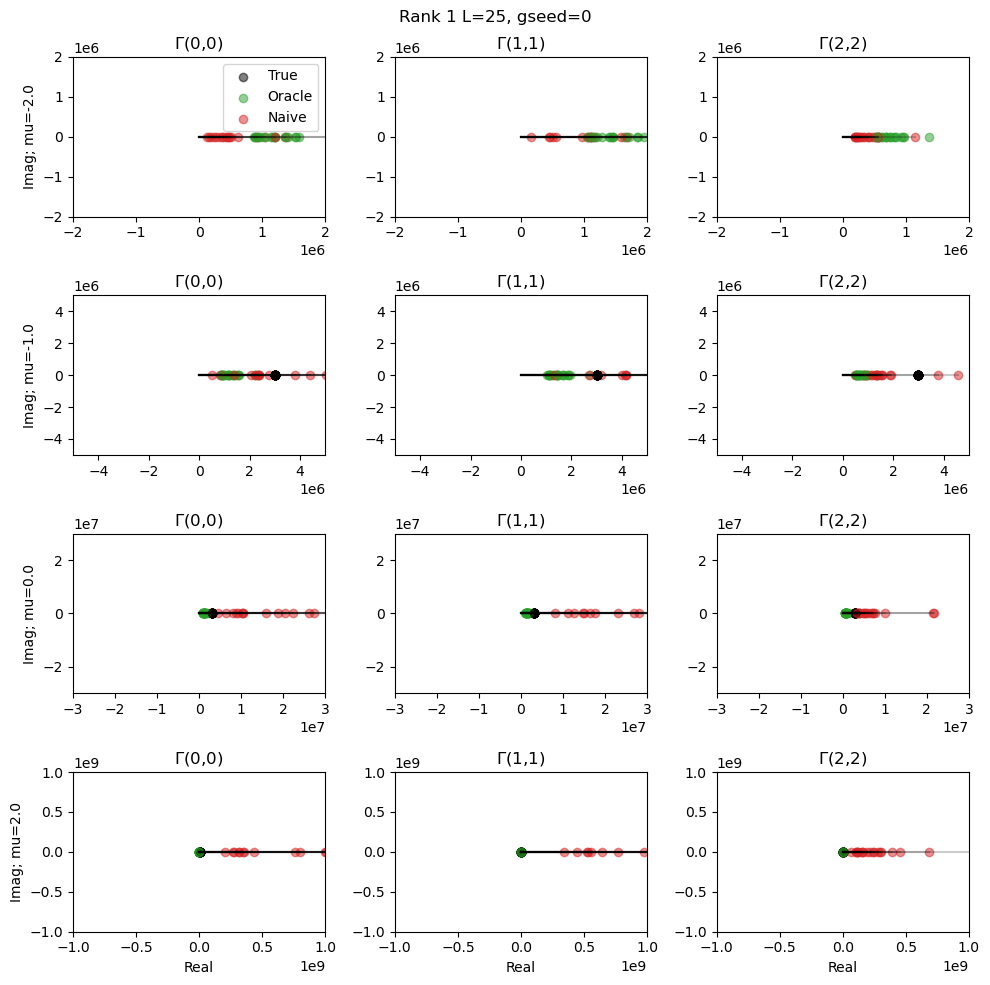

In [96]:
# fig, ax = plt.subplots()
lims = [2e6, 5e6, 3e7, 1e9]
pairs = [(0,0), (1,1), (2,2)]
fig, axs = plt.subplots(4,3,figsize=(10,10))
for m, mu in enumerate([-2.0, -1.0, 0.0, 2.0]):
    lim = lims[m]
    for i, (u, v) in enumerate(pairs):
        ax = axs[m,i]
        for seed in seeds:
            ccn_true, gamma_naive, gamma_oracle = get_sim_gamma_ests(K, L, seed, mu, gamma_seed=gamma_seed, rankname='fullrank')
            gamma_true = ccn_true.get_gamma()

            if m == 0 and i == 0 and seed == 0:
                ax.scatter(jnp.real(gamma_true[j,u,v]), jnp.imag(gamma_true[j,u,v]), color='k', alpha=0.5, label='True')
                ax.scatter(jnp.real(gamma_oracle[j,u,v]), jnp.imag(gamma_oracle[j,u,v]), color='tab:green', alpha=0.5, label='Oracle')
                ax.scatter(jnp.real(gamma_naive[j,u,v]), jnp.imag(gamma_naive[j,u,v]), color='tab:red', alpha=0.5, label='Naive')
                ax.legend()
            else:
                ax.scatter(jnp.real(gamma_true[j,u,v]), jnp.imag(gamma_true[j,u,v]), color='k', alpha=0.5)
                ax.scatter(jnp.real(gamma_oracle[j,u,v]), jnp.imag(gamma_oracle[j,u,v]), color='tab:green', alpha=0.5)
                ax.scatter(jnp.real(gamma_naive[j,u,v]), jnp.imag(gamma_naive[j,u,v]), color='tab:red', alpha=0.5)
            ax.plot([0, jnp.real(gamma_naive[j,u,v])], [0, jnp.imag(gamma_naive[j,u,v])], 'k', alpha=0.2)
            ax.set_xlim(-lim, lim)
            ax.set_ylim(-lim, lim)
            ax.set_title(r'$\Gamma$' + f'({u},{v})' )
            if i == 0:
                ax.set_ylabel(f'Imag; mu={mu}')
            if m == 3:
                ax.set_xlabel('Real')
    fig.suptitle(f'Full Rank L={L}, gseed={gamma_seed}')
            # ax.scatter(0,0, s=5, color='k', alpha=0.5)
    plt.tight_layout()

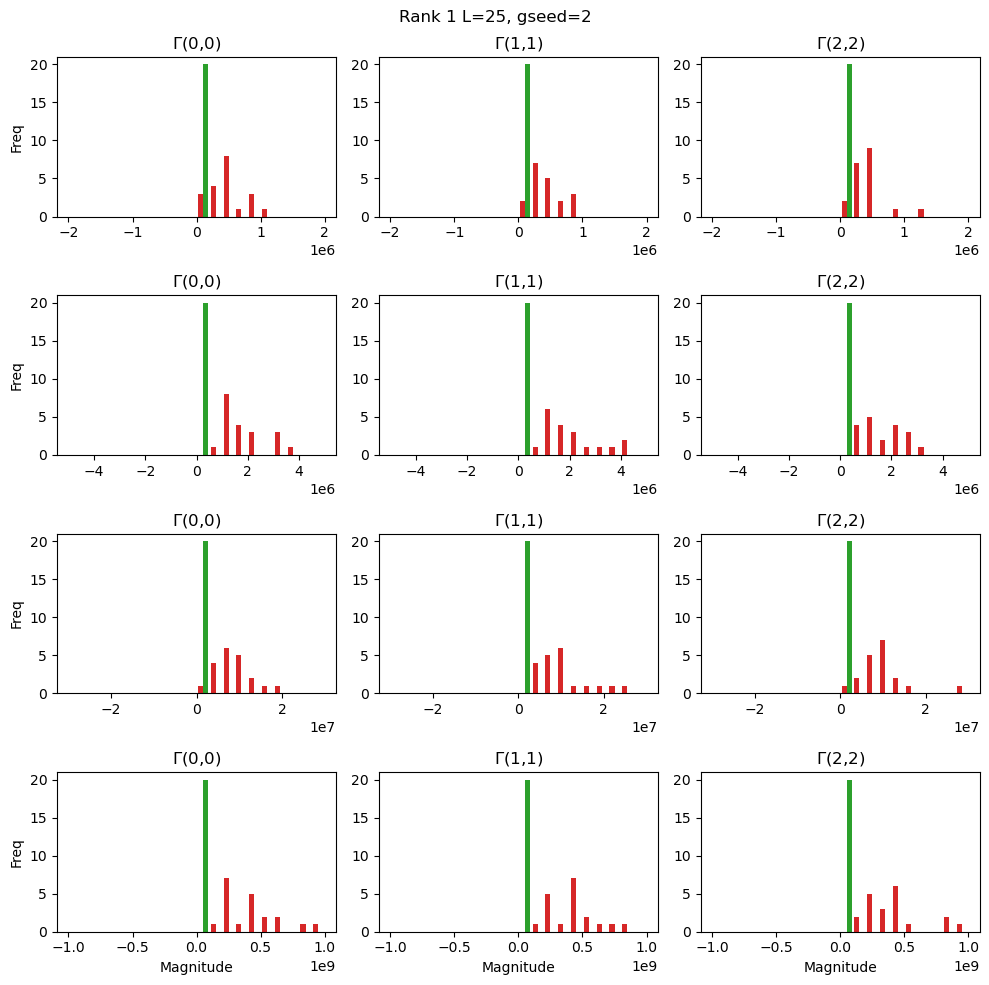

In [78]:
L = 25
# fig, axs = plt.subplots(mus.size, Ls.size, figsize = (12,8))
seeds = jnp.arange(20)
gamma_seed = 2
# fig, ax = plt.subplots()
lims = [2e6, 5e6, 3e7, 1e9]
fig, axs = plt.subplots(4,3,figsize=(10,10))
pairs = [(0,0), (1,1), (2,2)]
for m, mu in enumerate([-2.0, -1.0, 0.0, 2.0]):
    lim = lims[m]
    for i, (u, v) in enumerate(pairs):
        ax = axs[m,i]
        gdiag_naive = jnp.zeros((seeds.size))
        gdiag_oracle = jnp.zeros((seeds.size))
        for seed in seeds:
            # lrccn_true, eigvals_naive, eigvecs_naive, eigvals_oracle, eigvecs_oracle = get_sim_ests(K, L, seed, mu, gamma_seed=gamma_seed)
            lrccn_true, gamma_naive, gamma_oracle = get_sim_gamma_ests(K, L, seed, mu, gamma_seed=gamma_seed)
            gamma_true = lrccn_true.get_gamma()

            gdiag_naive = gdiag_naive.at[seed].set(gamma_naive[j,u,v].real)
            gdiag_naive = gdiag_naive.at[seed].set(gamma_naive[j,u,v].real)

        ests = jnp.stack([gdiag_naive, gdiag_oracle])
        colors = ['tab:red', 'tab:green']
        labels = ['naive', 'oracle']

        if m == 0 and i == 0:
            ax.hist(ests, bins=20, range=(-lim, lim), histtype='bar', color=colors, label=labels)
        else:
            ax.hist(ests, bins=20, range=(-lim, lim), histtype='bar', color=colors)

        ax.set_title(r'$\Gamma$' + f'({u},{v})' )
        if i == 0:
            ax.set_ylabel('Freq')
        if m == 3:
            ax.set_xlabel('Magnitude')
    fig.suptitle(f'Rank 1 L={L}, gseed={gamma_seed}')
            # ax.scatter(0,0, s=5, color='k', alpha=0.5)
    plt.tight_layout()

In [74]:
gdiag_naive

Array([[ 428789.97,  428789.97,  428789.97],
       [ 848288.7 ,  848288.7 ,  848288.7 ],
       [ 120000.  ,  120000.  ,  120000.  ],
       [ 463304.38,  463304.38,  463304.38],
       [ 359842.16,  359842.16,  359842.16],
       [ 499946.94,  499946.94,  499946.94],
       [ 442866.12,  442866.12,  442866.12],
       [ 545077.9 ,  545077.9 ,  545077.9 ],
       [ 160000.  ,  160000.  ,  160000.  ],
       [1179808.5 , 1179808.5 , 1179808.5 ],
       [ 159999.98,  159999.98,  159999.98],
       [ 432228.28,  432228.28,  432228.28],
       [ 557885.3 ,  557885.3 ,  557885.3 ],
       [ 527078.44,  527078.44,  527078.44],
       [ 860264.25,  860264.25,  860264.25],
       [ 904150.56,  904150.56,  904150.56],
       [ 397958.97,  397958.97,  397958.97],
       [ 319842.12,  319842.12,  319842.12],
       [ 356084.5 ,  356084.5 ,  356084.5 ],
       [ 601288.44,  601288.44,  601288.44]], dtype=float32)

In [26]:
from cohlib.jax.dists import CCN
def generate_fullrank_ccn(lcfg):

    assert lcfg.K == lcfg.rank
    gamma_seed = lcfg.gamma_seed
    N = lcfg.num_freqs
    target_freq_ind = lcfg.target_freq_ind
    gamma_seed = lcfg.gamma_seed

    nz = jnp.array([target_freq_ind])

    freqs = jnp.arange(N)
    gamma_seed = 3
    Nnz = 1
    gamma = jnp.zeros((Nnz, K, K), dtype=complex)
    gamma_rk = jr.key(gamma_seed)
    rksplit = jr.split(gamma_rk, Nnz)
    for j in range(Nnz):
        if Nnz == 1: 
            rk = gamma_rk
        else:
            rk = rksplit[j]

        rksplit2 = jr.split(rk, 2)
        Q, _ = jnp.linalg.qr(jr.normal(rksplit2[0], (K,K)) + jr.normal(rksplit2[1], (K,K))*1j)

        Q = rotate_eigvecs(Q[None,:,:])

        gamma_j = Q[j,:,:] @ jnp.diag(jnp.array([1e6, 1e3, 1e2])*K) @ Q[j,:,:].conj().T
        gamma = gamma.at[j,:,:].set(gamma_j)

    ccn = CCN(gamma, freqs, nz)

    return ccn

In [27]:
lcfg = omega(temp_func(K, L, seed, mu))

In [28]:
lcfg.rank = lcfg.K
lcfg

{'latent_type': 'basic_single_log', 'K': 3, 'rank': 3, 'num_freqs': 500, 'target_freq_ind': 9, 'scale_power_target': 1000000.0, 'L': 5, 'gamma_seed': 0, 'seed': 0}

In [29]:
ccn = generate_fullrank_ccn(lcfg)

In [30]:
rk = jr.key(5)
zs_nz = ccn.sample_nz(rk, 5)

num_freqs = ccn.freqs.size
nz = ccn.nz

zs = jnp.zeros((num_freqs, lcfg.K, lcfg.L), dtype=complex)
zs = zs.at[nz,:,:].set(zs_nz)
zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)

In [31]:
_, evtest = jnp.linalg.eigh(Q)

NameError: name 'Q' is not defined

In [ ]:
jnp.round(evtest, 3)

Array([[[ 0.41900003+0.j        ,  0.536     +0.j        ,
         -0.73300004-0.j        ],
        [-0.712     +0.06j      , -0.125     +0.367j     ,
         -0.49800003+0.30200002j],
        [-0.215     +0.517j     , -0.18900001-0.726j     ,
         -0.261     -0.23500001j]]], dtype=complex64)

In [ ]:
jnp.round(Q[0,:,::-1], 3)

Array([[ 0.6       +0.j        ,  0.708     -0.j        ,
         0.37300003-0.j        ],
       [-0.19900002+0.209j     ,  0.522     +0.052j     ,
        -0.67200005-0.43600002j],
       [ 0.638     +0.386j     , -0.46400002-0.093j     ,
        -0.147     -0.44500002j]], dtype=complex64)

In [ ]:
U = rotate_eigvecs(Q[None,:,:])
jnp.round(U[0,:,:] @ U[0,:,:].conj().T)

Array([[[1.-0.j],
        [1.+0.j],
        [1.-0.j]],

       [[1.+0.j],
        [1.+0.j],
        [1.-0.j]],

       [[1.-0.j],
        [1.+0.j],
        [1.-0.j]]], dtype=complex64)

In [ ]:
u1 = lrccn_true.eigvecs.squeeze()
rk = jr.key(gamma_seed+1)
rk_split = jr.split(rk, 2)
r2 = jr.normal(rk_split[0], (u1.size,)) + jr.normal(rk_split[1], (u1.size,))*1j


v2 = r2 / jnp.linalg.norm(r2)
u2 = u1 - jnp.dot(u1, v2.conj())*v2
u2 = u2 / jnp.linalg.norm(u2)

In [ ]:
jnp.dot(u1, u2.conj()).real

Array(0.9605857, dtype=float32)

In [ ]:
jnp.linalg.norm(v2)

Array(1., dtype=float32)

In [ ]:
jnp.dot(u1, u2.conj())

Array(0.9605857+1.4901161e-08j, dtype=complex64)

In [ ]:
jnp.linalg.norm(u2)

Array(1., dtype=float32)

In [ ]:
print(lrccn_true.get_gamma().real)
print(gamma_oracle.real)
print(gamma_naive.real)

In [12]:
lrccn_true.get_gamma().imag

Array([[[ 0.000000e+00, -8.113733e+05,  8.692799e+05],
        [ 8.113733e+05, -3.125000e-02, -9.091970e+05],
        [-8.692798e+05,  9.091969e+05,  0.000000e+00]]], dtype=float32)

In [7]:
eigvals_model, eigvecs_model = get_fullrank_model_ests(3, 5, 4, 0.0, init='empirical')

In [8]:
eigvals_model

Array([[3579310.2  ,   94006.07 ,   30304.203]], dtype=float32)

In [7]:
lrccn_true.eigvals[0,0]

Array(3000000., dtype=float32)

### what do we want to inspect? 
- relationship between behavior of naive estimator and fullrank/lowrank model behavior 

In [14]:
def get_eigval_sim_model_results(model_load_func, mu, L, init, legend=False, num_samples=100):
    j = 0
    eigrank = 1
    K = 3
    naive_ests = jnp.zeros(num_samples)
    oracle_ests = jnp.zeros(num_samples)
    model_ests = jnp.zeros(num_samples)
    true_vals = jnp.zeros(num_samples)

    for seed in range(0, num_samples):
        lrccn_true, eigvals_naive, eigvecs_naive, eigvals_oracle, eigvecs_oracle = get_sim_ests(K, L, seed, mu)
        eigvals_model, eigvecs_model = model_load_func(K, L, seed, mu, init)

        naive_ests = naive_ests.at[seed].set(eigvals_naive[j,eigrank-1])
        oracle_ests = oracle_ests.at[seed].set(eigvals_oracle[j,eigrank-1])
        model_ests = model_ests.at[seed].set(eigvals_model[j,eigrank-1])
        true_vals = true_vals.at[seed].set((lrccn_true.eigvals[j,eigrank-1]))

    return true_vals, naive_ests, oracle_ests, model_ests

def get_eigvec_sim_model_results(model_load_func, func, dim, mu, L, init, legend=False, num_samples=100):
    j = 0
    eigrank = 1
    K = 3

    naive_ests = jnp.zeros(num_samples)
    oracle_ests = jnp.zeros(num_samples)
    model_ests = jnp.zeros(num_samples)
    true_vals = jnp.zeros(num_samples)
    for seed in range(0, num_samples):
        lrccn_true, eigvals_naive, eigvecs_naive, eigvals_oracle, eigvecs_oracle = get_sim_ests(K, L, seed, mu)
        eigvals_model, eigvecs_model = model_load_func(K, L, seed, mu, init)

        naive_ests = naive_ests.at[seed].set(func(rotate_eigvecs(eigvecs_naive)[j,dim,eigrank-1]))
        oracle_ests = oracle_ests.at[seed].set(func(rotate_eigvecs(eigvecs_oracle)[j,dim,eigrank-1]))
        model_ests = model_ests.at[seed].set(func(rotate_eigvecs(eigvecs_model)[j,dim,eigrank-1]))
        true_vals = true_vals.at[seed].set(func(rotate_eigvecs(lrccn_true.eigvecs)[j,dim,eigrank-1]))

    return true_vals, naive_ests, oracle_ests, model_ests

In [33]:
L = 3
mu = -2.0
model_func = get_fullrank_model_ests
true_eigvals, naive_eigvals, oracle_eigvals, model_eigvals = get_eigval_sim_model_results(model_func, mu, L, init='empirical', num_samples=20)

In [41]:
def get_fullrank_model_emtrack(K, L, seed, mu, init):
    if init == 'flat':
        res_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log/window1000/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/model-simple_inherit_latent_fullrank/inherit-True/m_step-full-rank-standard/{init}-init_6.0/newton-10_em-20/res.pkl'
    if init == 'empirical':
        res_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log/window1000/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/model-simple_inherit_latent_fullrank/inherit-True/m_step-full-rank-standard/{init}-init/newton-10_em-20/res.pkl'

    res_load = pickle_open(res_path)

    track = res_load['track']
    return track

def get_lowrank_model_emtrack(K, L, seed, mu, init):
    if init == 'flat':
        res_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log/window1000/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/model-simple_inherit_latent_lowrank_eigh/inherit-True/m_step-low-rank-eigh/{init}-init_6.0_eigvals-fit_eigvecs-fit/newton-10_em-20/res.pkl'
    if init == 'empirical':
        res_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log/window1000/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/model-simple_inherit_latent_lowrank_eigh/inherit-True/m_step-low-rank-eigh/{init}-init_eigvals-fit_eigvecs-fit/newton-10_em-20/res.pkl'

    res_load = pickle_open(res_path)
    track = res_load['track'] 
    return track

In [66]:
K = 3
L = 5
seed = 0
mu = 0.0
init = 'empirical'

track = get_fullrank_model_emtrack(K, L, seed, mu, init)

In [67]:
j = 0
jnp.stack([get_eigvals(x)[j,0] for x in track['ccn']])

Array([18329170. ,  4237398. ,  3991038.2,  3919104. ,  3908584.5,
        3922211.5,  3940077. ,  3956060. ,  3969262. ,  3980055. ,
        3988951.8,  3996381.8,  4002664. ,  4008037. ,  4012680.8,
        4016730.2,  4020290. ,  4023440.5,  4026248. ,  4028761. ,
        4031023.2], dtype=float32)

In [68]:
eigvals_naive

Array([[17946584. ,  2569500.8,   509047.2]], dtype=float32)

In [116]:
def plot_sim_eigvals_hline(ax, K, L, seed, mu, eigrank=1):
    lrccn_true, eigvals_naive, eigvecs_naive, eigvals_oracle, eigvecs_oracle = get_sim_ests(K, L, seed, mu)
    ax.axhline(eigvals_naive[j,eigrank-1], color='tab:red')
    ax.axhline(eigvals_oracle[j,eigrank-1], color='tab:green')
    ax.axhline(lrccn_true.eigvals[j,eigrank-1], color='k')

def plot_eigvals_fullrank_em(ax, init, K, L, seed, mu, eigrank=1):
    j = 0
    fullrank_track = get_fullrank_model_emtrack(K, L, seed, mu, init)
    eigvals_em = jnp.stack([get_eigvals(x)[j,eigrank-1] for x in fullrank_track['ccn']])
    
    ax.plot(eigvals_em, color='tab:blue')

def plot_eigvals_lowrank_em(ax, init, K, L, seed, mu, eigrank=1):
    j = 0
    lowrank_track = get_lowrank_model_emtrack(K, L, seed, mu, init)
    eigvals_em = jnp.stack([x.eigvals[j,eigrank-1] for x in lowrank_track['lrccn']])
    
    ax.plot(eigvals_em, linestyle='--', color='tab:blue')

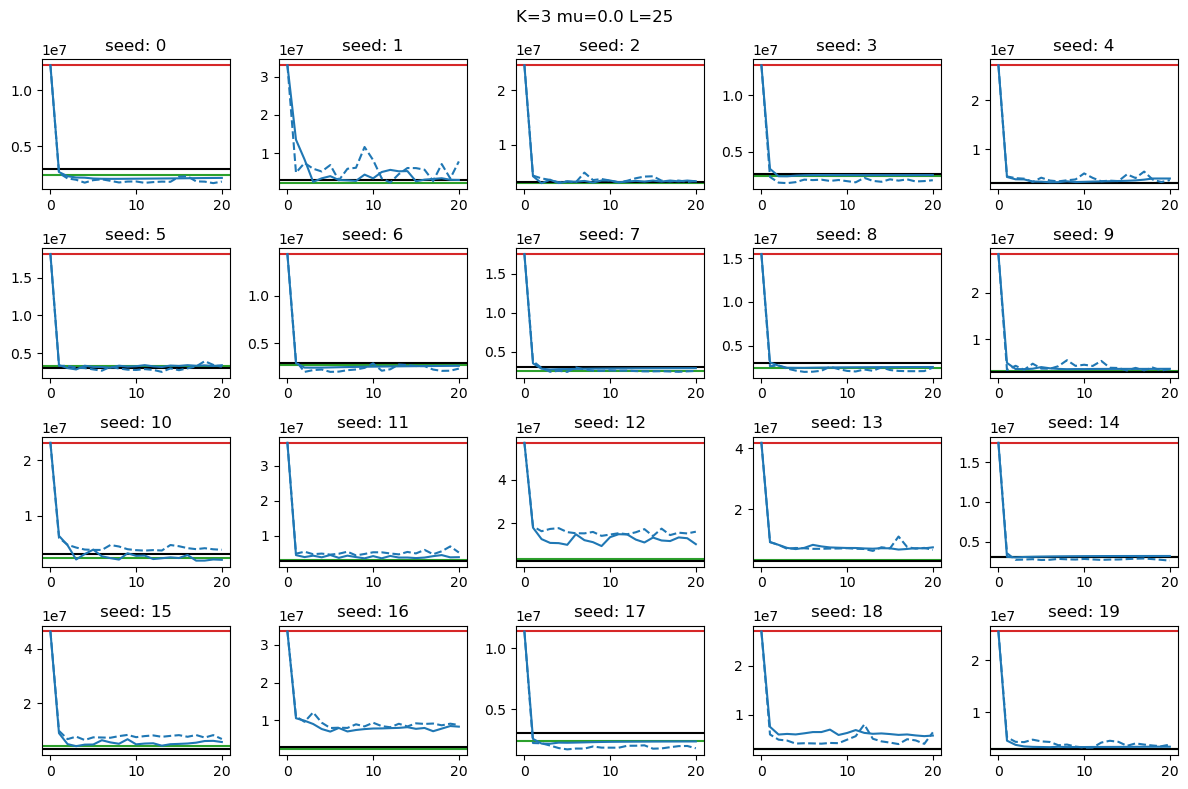

In [123]:
K = 3
L = 25
seed = 0
mu = 0.0
# fig, ax = plt.subplots(3,3,figsize=(5,3))
fig = plt.figure(figsize=(12,8))
start = 0
for seed in range(start, start+20):
    ax = fig.add_subplot(4,5,seed-start+1)
    plot_sim_eigvals_hline(ax, K, L, seed, mu)
    plot_eigvals_fullrank_em(ax, 'empirical', K, L, seed, mu)
    plot_eigvals_lowrank_em(ax, 'empirical', K, L, seed, mu)
    ax.set_title(f'seed: {seed}')
fig.suptitle(f'K={K} mu={mu} L={L}')
plt.tight_layout()

In [124]:
def plot_sim_eigvecs_hline(ax, func, dim, K, L, seed, mu, eigrank=1):
    j = 0
    lrccn_true, eigvals_naive, eigvecs_naive, eigvals_oracle, eigvecs_oracle = get_sim_ests(K, L, seed, mu)
    ax.axhline(func(rotate_eigvecs(lrccn_true.eigvecs)[j,dim,eigrank-1]), color='k')
    ax.axhline(func(rotate_eigvecs(eigvecs_oracle)[j,dim,eigrank-1]), color='tab:green', linestyle='-.')
    ax.axhline(func(rotate_eigvecs(eigvecs_naive)[j,dim,eigrank-1]), color='tab:red')

def plot_eigvecs_fullrank_em(ax, func, dim, init, K, L, seed, mu, eigrank=1):
    j = 0
    fullrank_track = get_fullrank_model_emtrack(K, L, seed, mu, init)
    eigvecs_em = jnp.stack([rotate_eigvecs(get_eigvecs(x))[j,dim,eigrank-1] for x in fullrank_track['ccn']])
    
    ax.plot(func(eigvecs_em), color='tab:blue')

def plot_eigvecs_lowrank_em(ax, func, dim, init, K, L, seed, mu, eigrank=1):
    j = 0
    lowrank_track = get_lowrank_model_emtrack(K, L, seed, mu, init)
    eigvecs_em = jnp.stack([rotate_eigvecs(x.eigvecs)[j,dim,eigrank-1] for x in lowrank_track['lrccn']])
    
    ax.plot(func(eigvecs_em), linestyle='--', color='tab:blue')

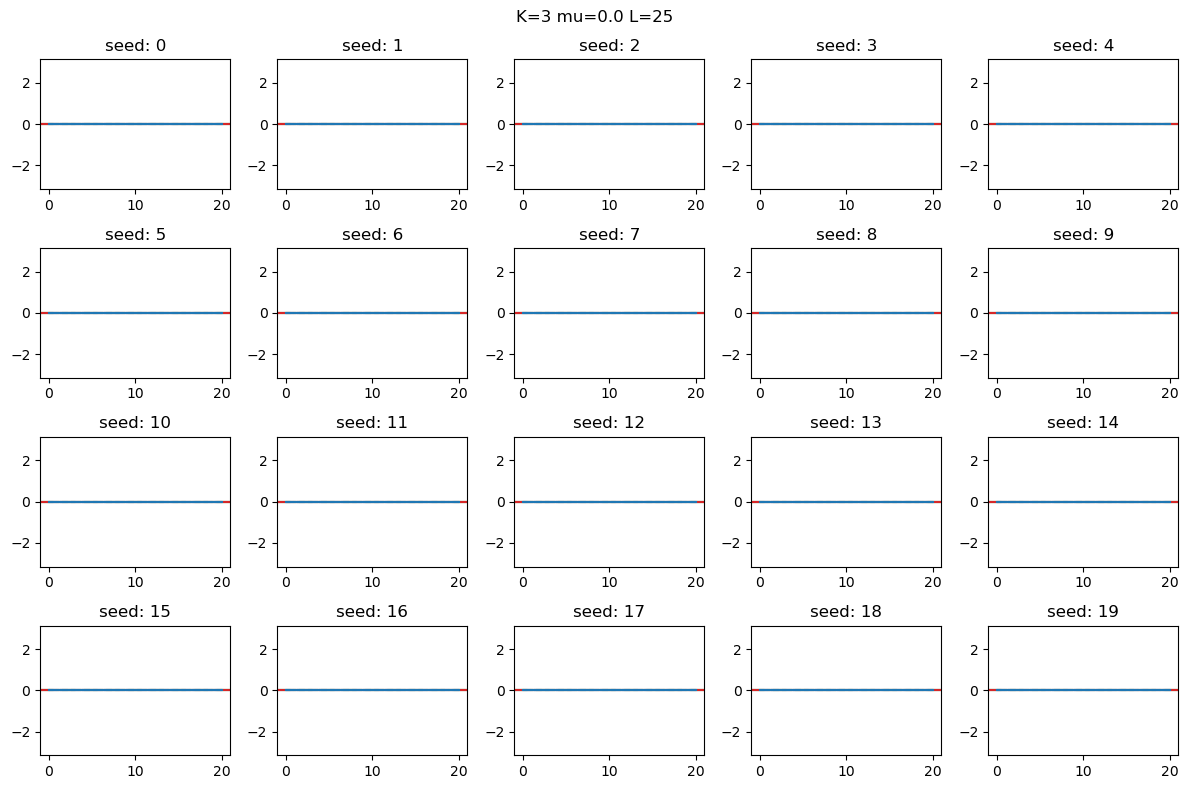

In [128]:
func = jnp.angle
dim = 0
fig = plt.figure(figsize=(12,8))
start = 0
for seed in range(start, start+20):
    ax = fig.add_subplot(4,5,seed-start+1)
    plot_sim_eigvecs_hline(ax, func, dim, K, L, seed, mu)
    plot_eigvecs_fullrank_em(ax, func, dim, 'empirical', K, L, seed, mu)
    plot_eigvecs_lowrank_em(ax, func, dim, 'empirical', K, L, seed, mu)
    ax.set_title(f'seed: {seed}')
    if func == jnp.angle:
        ax.set_ylim([-jnp.pi, jnp.pi])
fig.suptitle(f'K={K} mu={mu} L={L}')
plt.tight_layout()

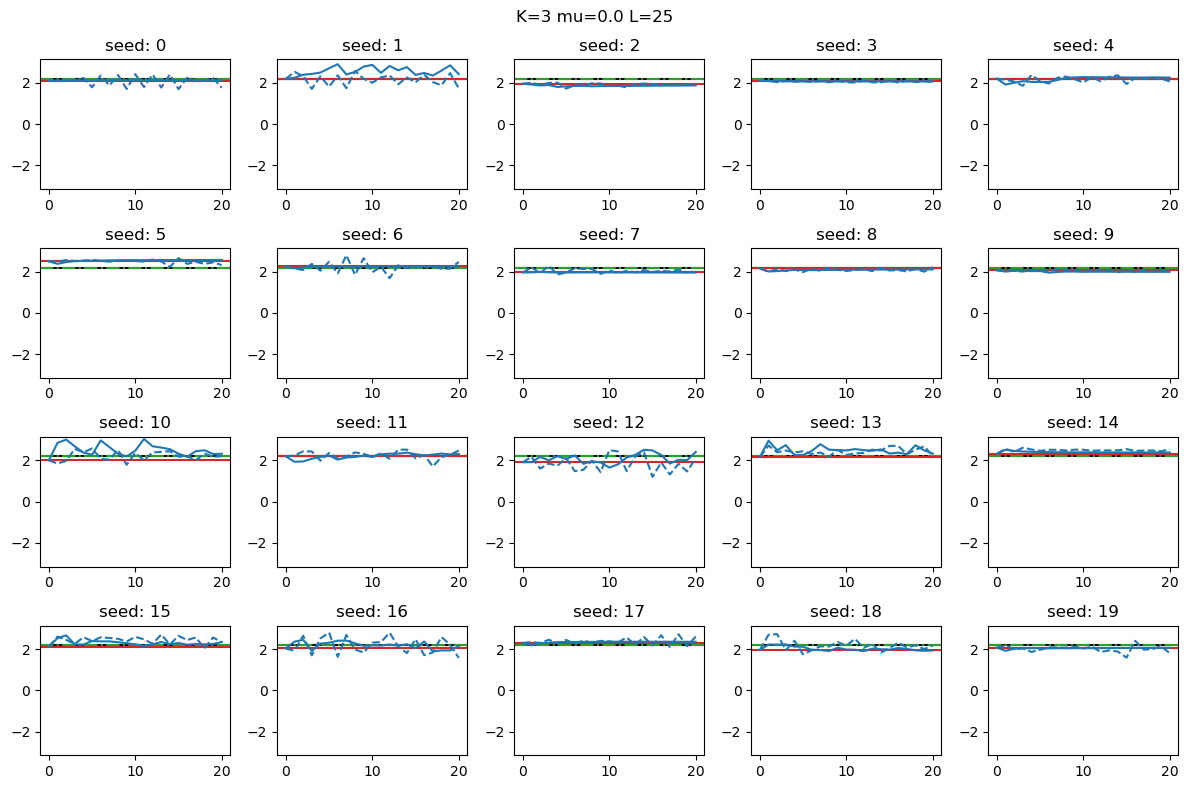

In [127]:
func = jnp.angle
dim = 1
fig = plt.figure(figsize=(12,8))
start = 0
for seed in range(start, start+20):
    ax = fig.add_subplot(4,5,seed-start+1)
    plot_sim_eigvecs_hline(ax, func, dim, K, L, seed, mu)
    plot_eigvecs_fullrank_em(ax, func, dim, 'empirical', K, L, seed, mu)
    plot_eigvecs_lowrank_em(ax, func, dim, 'empirical', K, L, seed, mu)
    ax.set_title(f'seed: {seed}')
    if func == jnp.angle:
        ax.set_ylim([-jnp.pi, jnp.pi])
fig.suptitle(f'K={K} mu={mu} L={L}')
plt.tight_layout()

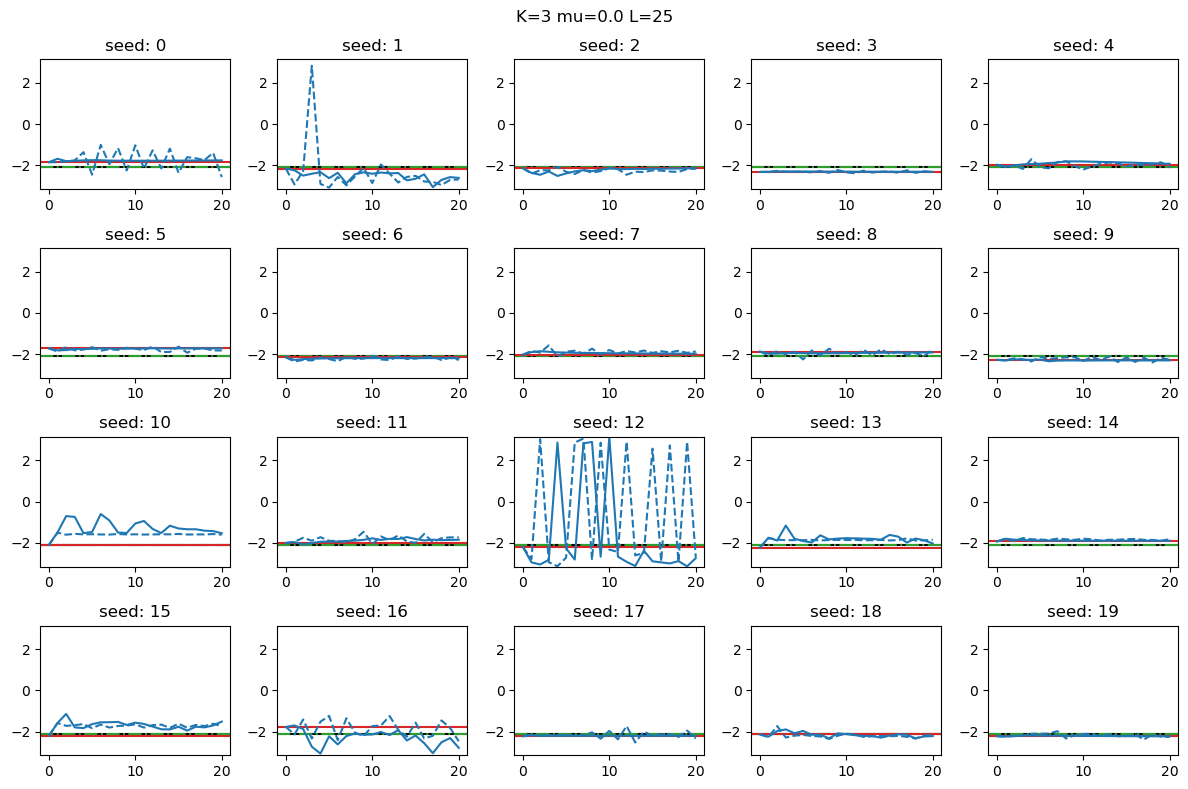

In [126]:
func = jnp.angle
dim = 2
fig = plt.figure(figsize=(12,8))
start = 0
for seed in range(start, start+20):
    ax = fig.add_subplot(4,5,seed-start+1)
    plot_sim_eigvecs_hline(ax, func, dim, K, L, seed, mu)
    plot_eigvecs_fullrank_em(ax, func, dim, 'empirical', K, L, seed, mu)
    plot_eigvecs_lowrank_em(ax, func, dim, 'empirical', K, L, seed, mu)
    ax.set_title(f'seed: {seed}')
    if func == jnp.angle:
        ax.set_ylim([-jnp.pi, jnp.pi])
fig.suptitle(f'K={K} mu={mu} L={L}')
plt.tight_layout()

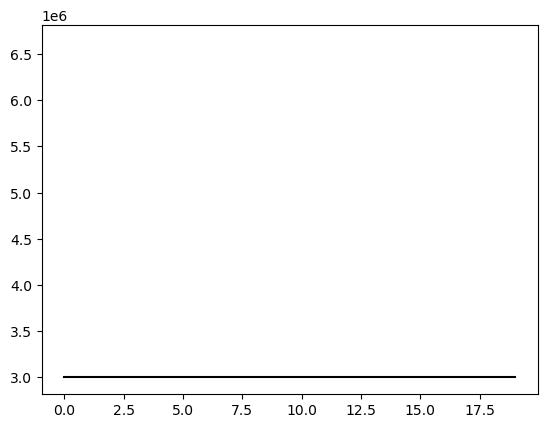

In [34]:
plt.plot(true_eigvals, color='k')
# plt.plot(naive_eigvals, color='tab:red')
# plt.plot(oracle_eigvals, color='tab:green')
plt.plot(model_eigvals, color='tab:blue')

In [31]:
model_func = get_fullrank_model_ests

Text(0.5, 0.98, 'Eigvals')

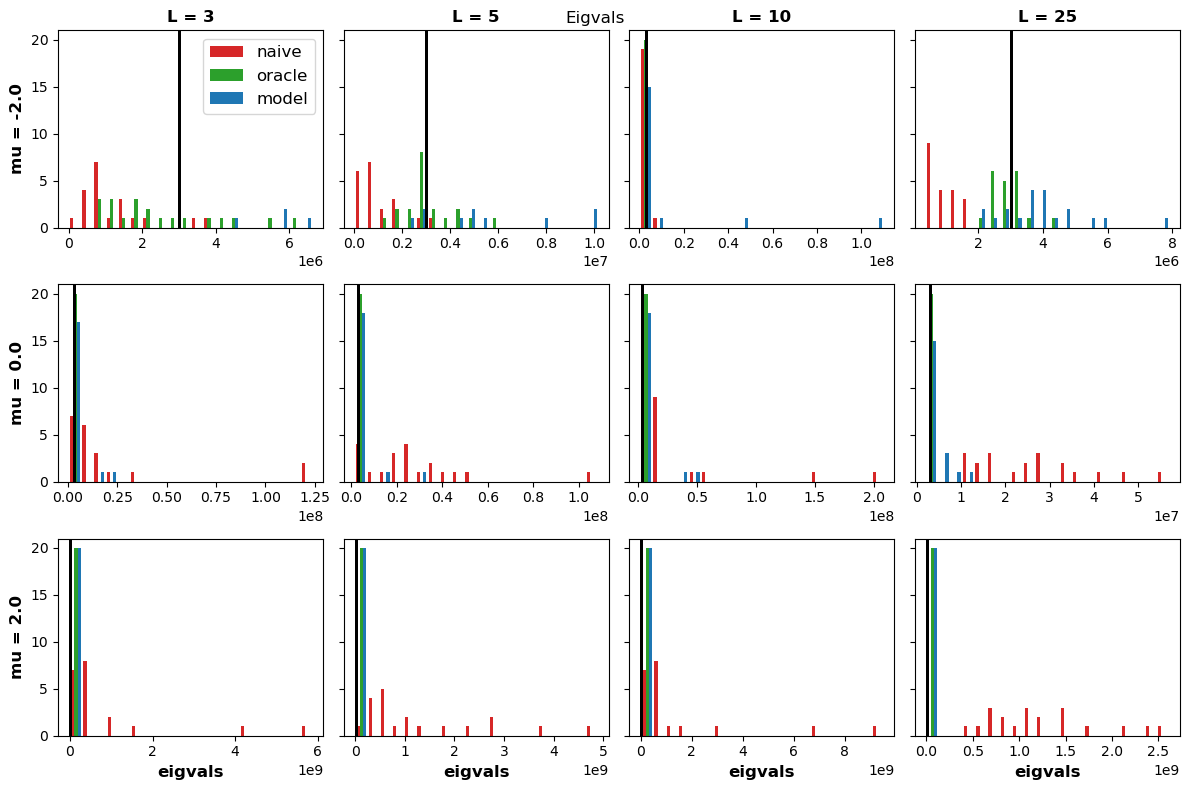

In [21]:
mus = jnp.array([-2.0, 0.0, 2.0])
Ls = jnp.array([3, 5, 10, 25])
# mus = jnp.array([-2.0, 0.0])
# Ls = jnp.array([3, 5])
fig, ax = plt.subplots(mus.size, Ls.size, figsize=(12,8), sharex=False, sharey=True)
for m, mu in enumerate(mus):
    for ell, L in enumerate(Ls):
        plot_eigval_sim_model_hist(ax[m,ell], model_func, mu, L, init='empirical', num_samples=20)
        if m == 0 and ell == 0:
            ax[m,ell].legend(prop={'size': 12})
        if ell == 0:
            ax[m,ell].set_ylabel(f'mu = {mu}', fontweight='bold', fontsize=12)
        if m == 0:
            ax[m,ell].set_title(f'L = {L}', fontweight='bold', fontsize=12)
        if m == mus.size - 1:
            ax[m,ell].set_xlabel('eigvals', fontweight='bold', fontsize=12)
plt.tight_layout()
fig.suptitle('Eigvals')

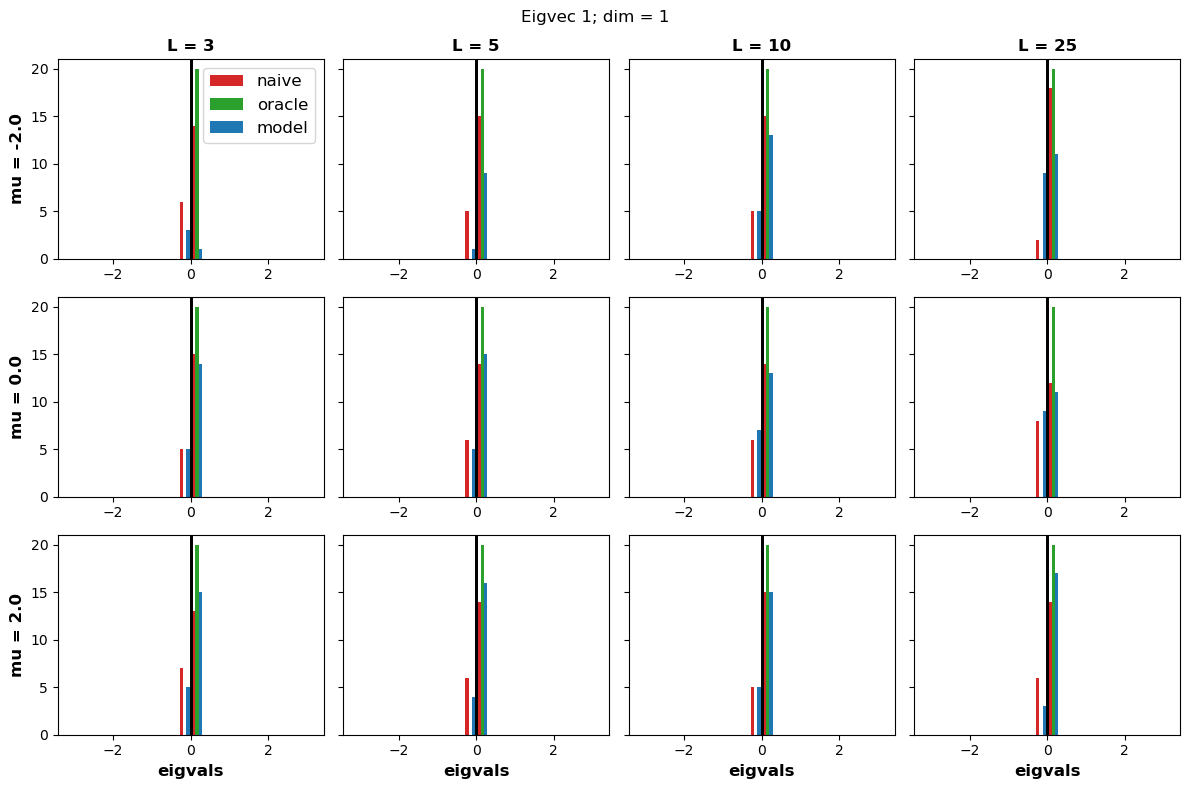

In [32]:
mus = jnp.array([-2.0, 0.0, 2.0])
Ls = jnp.array([3, 5, 10, 25])
# mus = jnp.array([-2.0, 0.0])
# Ls = jnp.array([3, 5])
dim = 0
fig, ax = plt.subplots(mus.size, Ls.size, figsize=(12,8), sharex=False, sharey=True)
for m, mu in enumerate(mus):
    for ell, L in enumerate(Ls):
        plot_eigvec_sim_model_hist(ax[m,ell], model_func, jnp.angle, dim, mu, L, init='empirical', num_samples=20)
        if m == 0 and ell == 0:
            ax[m,ell].legend(prop={'size': 12})
        if ell == 0:
            ax[m,ell].set_ylabel(f'mu = {mu}', fontweight='bold', fontsize=12)
        if m == 0:
            ax[m,ell].set_title(f'L = {L}', fontweight='bold', fontsize=12)
        if m == mus.size - 1:
            ax[m,ell].set_xlabel('eigvals', fontweight='bold', fontsize=12)
fig.suptitle(f'Eigvec 1; dim = {dim+1}')
plt.tight_layout()

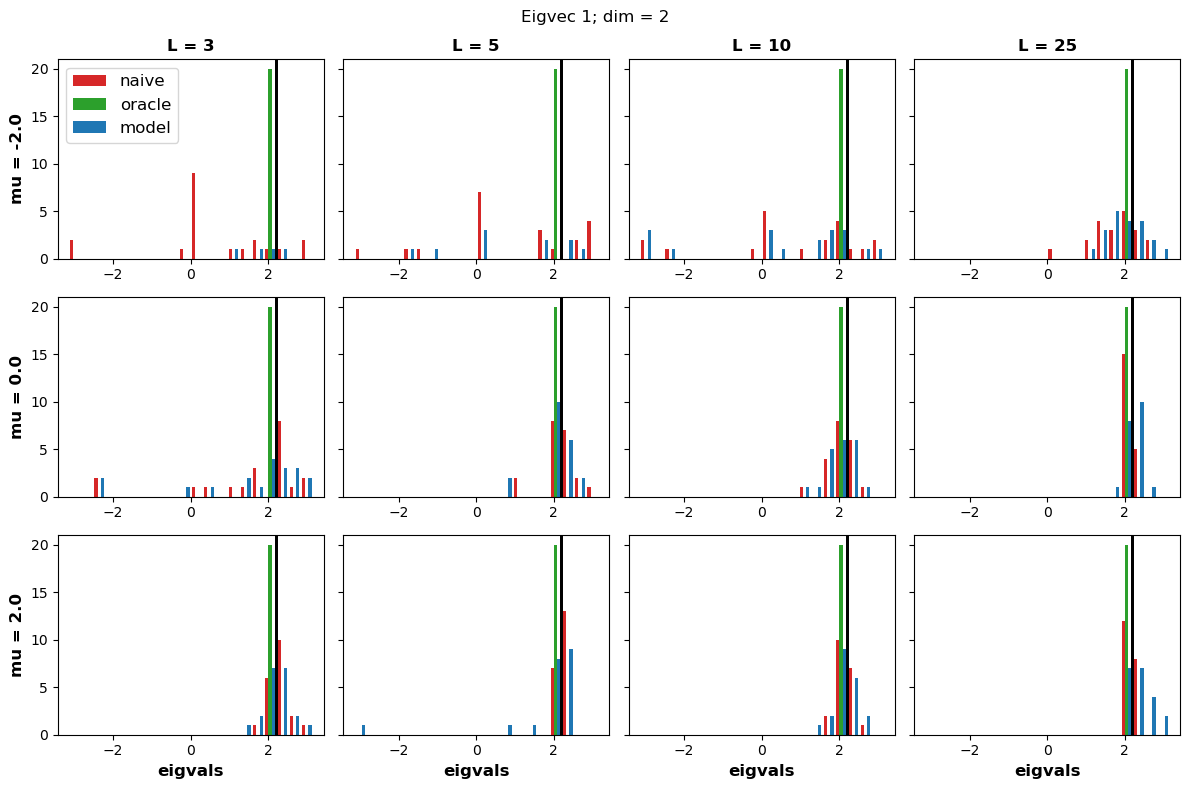

In [26]:
mus = jnp.array([-2.0, 0.0, 2.0])
Ls = jnp.array([3, 5, 10, 25])
# mus = jnp.array([-2.0, 0.0])
# Ls = jnp.array([3, 5])
dim = 1
fig, ax = plt.subplots(mus.size, Ls.size, figsize=(12,8), sharex=False, sharey=True)
for m, mu in enumerate(mus):
    for ell, L in enumerate(Ls):
        plot_eigvec_sim_model_hist(ax[m,ell], model_func, jnp.angle, dim, mu, L, init='empirical', num_samples=20)
        if m == 0 and ell == 0:
            ax[m,ell].legend(prop={'size': 12})
        if ell == 0:
            ax[m,ell].set_ylabel(f'mu = {mu}', fontweight='bold', fontsize=12)
        if m == 0:
            ax[m,ell].set_title(f'L = {L}', fontweight='bold', fontsize=12)
        if m == mus.size - 1:
            ax[m,ell].set_xlabel('eigvals', fontweight='bold', fontsize=12)
fig.suptitle(f'Eigvec 1; dim = {dim+1}')
plt.tight_layout()

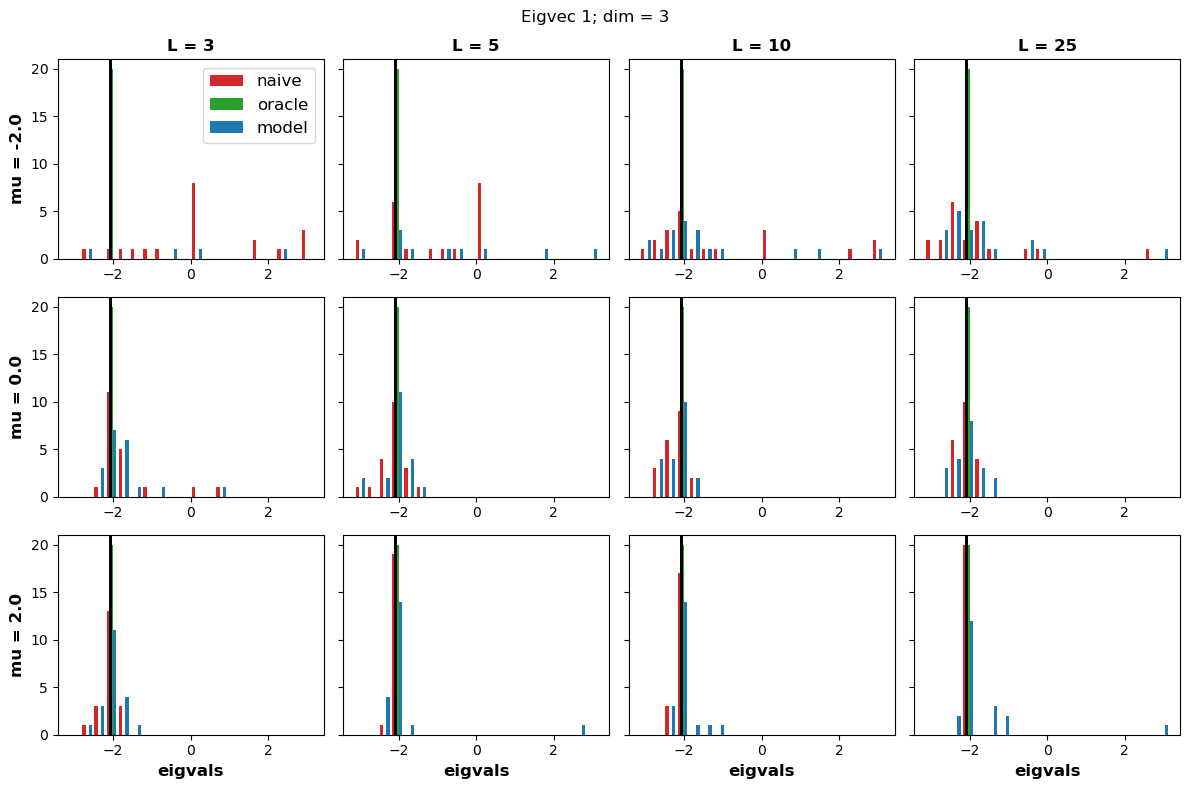

In [24]:
mus = jnp.array([-2.0, 0.0, 2.0])
Ls = jnp.array([3, 5, 10, 25])
# mus = jnp.array([-2.0, 0.0])
# Ls = jnp.array([3, 5])
dim = 2
fig, ax = plt.subplots(mus.size, Ls.size, figsize=(12,8), sharex=False, sharey=True)
for m, mu in enumerate(mus):
    for ell, L in enumerate(Ls):
        plot_eigvec_sim_model_hist(ax[m,ell], model_func, jnp.angle, dim, mu, L, init='empirical', num_samples=20)
        if m == 0 and ell == 0:
            ax[m,ell].legend(prop={'size': 12})
        if ell == 0:
            ax[m,ell].set_ylabel(f'mu = {mu}', fontweight='bold', fontsize=12)
        if m == 0:
            ax[m,ell].set_title(f'L = {L}', fontweight='bold', fontsize=12)
        if m == mus.size - 1:
            ax[m,ell].set_xlabel('eigvals', fontweight='bold', fontsize=12)
fig.suptitle(f'Eigvec 1; dim = {dim+1}')
plt.tight_layout()

In [27]:
model_func = get_lowrank_model_ests

Text(0.5, 0.98, 'Eigvals')

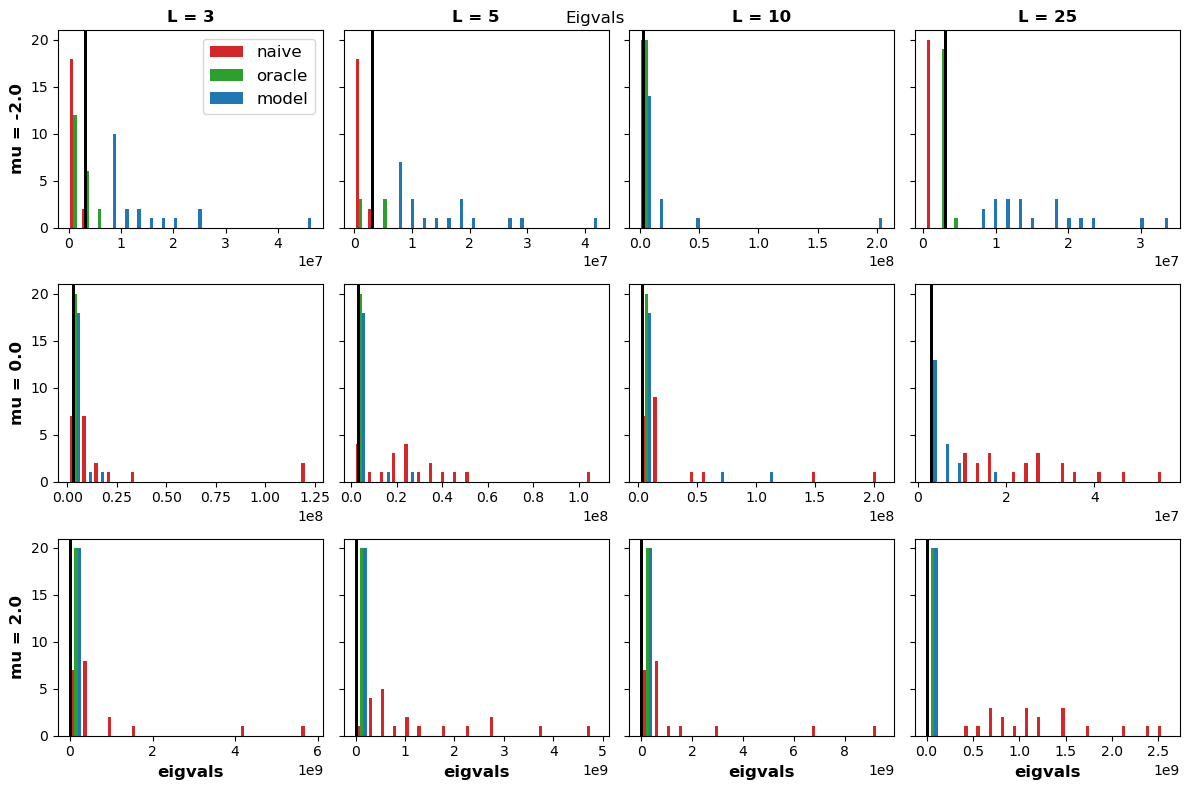

In [ ]:
mus = jnp.array([-2.0, 0.0, 2.0])
Ls = jnp.array([3, 5, 10, 25])
# mus = jnp.array([-2.0, 0.0])
# Ls = jnp.array([3, 5])
fig, ax = plt.subplots(mus.size, Ls.size, figsize=(12,8), sharex=False, sharey=True)
for m, mu in enumerate(mus):
    for ell, L in enumerate(Ls):
        plot_eigval_sim_model_hist(ax[m,ell], model_func, mu, L, init='empirical', num_samples=20)
        if m == 0 and ell == 0:
            ax[m,ell].legend(prop={'size': 12})
        if ell == 0:
            ax[m,ell].set_ylabel(f'mu = {mu}', fontweight='bold', fontsize=12)
        if m == 0:
            ax[m,ell].set_title(f'L = {L}', fontweight='bold', fontsize=12)
        if m == mus.size - 1:
            ax[m,ell].set_xlabel('eigvals', fontweight='bold', fontsize=12)
plt.tight_layout()
fig.suptitle('Eigvals')

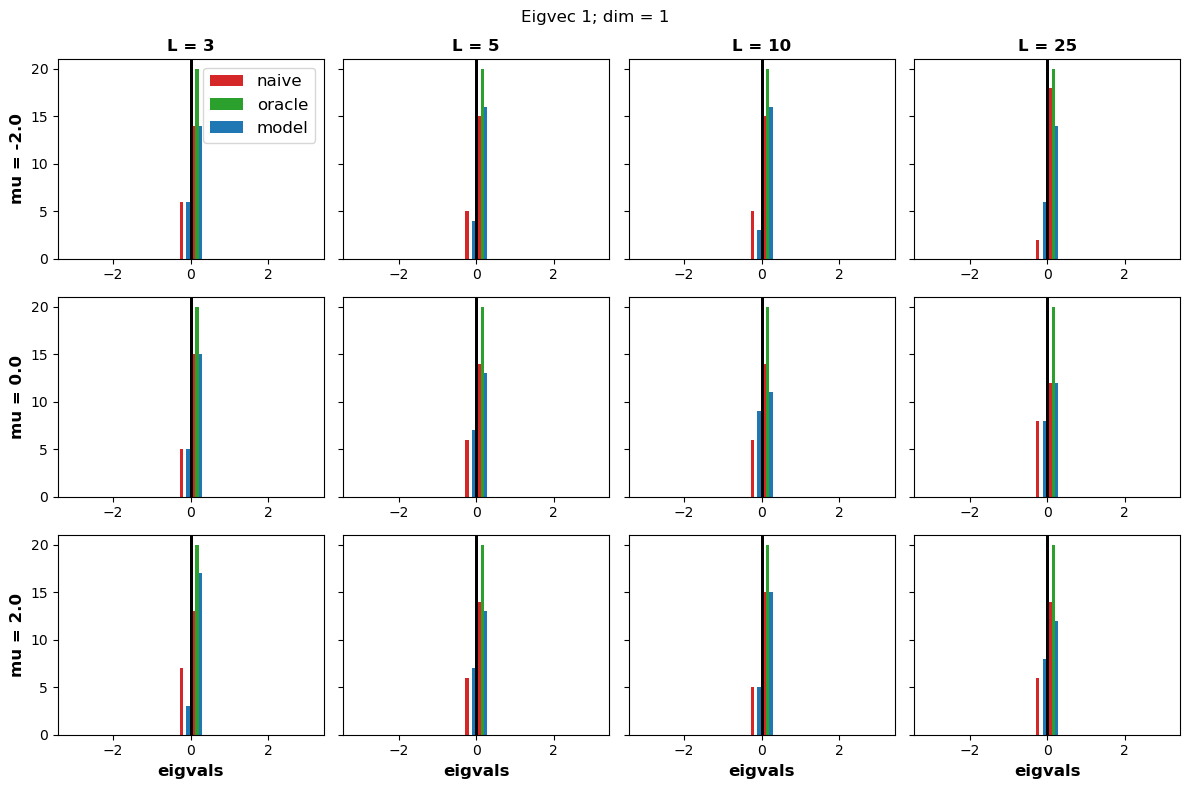

In [28]:
mus = jnp.array([-2.0, 0.0, 2.0])
Ls = jnp.array([3, 5, 10, 25])
# mus = jnp.array([-2.0, 0.0])
# Ls = jnp.array([3, 5])
dim = 0
fig, ax = plt.subplots(mus.size, Ls.size, figsize=(12,8), sharex=False, sharey=True)
for m, mu in enumerate(mus):
    for ell, L in enumerate(Ls):
        plot_eigvec_sim_model_hist(ax[m,ell], model_func, jnp.angle, dim, mu, L, init='empirical', num_samples=20)
        if m == 0 and ell == 0:
            ax[m,ell].legend(prop={'size': 12})
        if ell == 0:
            ax[m,ell].set_ylabel(f'mu = {mu}', fontweight='bold', fontsize=12)
        if m == 0:
            ax[m,ell].set_title(f'L = {L}', fontweight='bold', fontsize=12)
        if m == mus.size - 1:
            ax[m,ell].set_xlabel('eigvals', fontweight='bold', fontsize=12)
fig.suptitle(f'Eigvec 1; dim = {dim+1}')
plt.tight_layout()

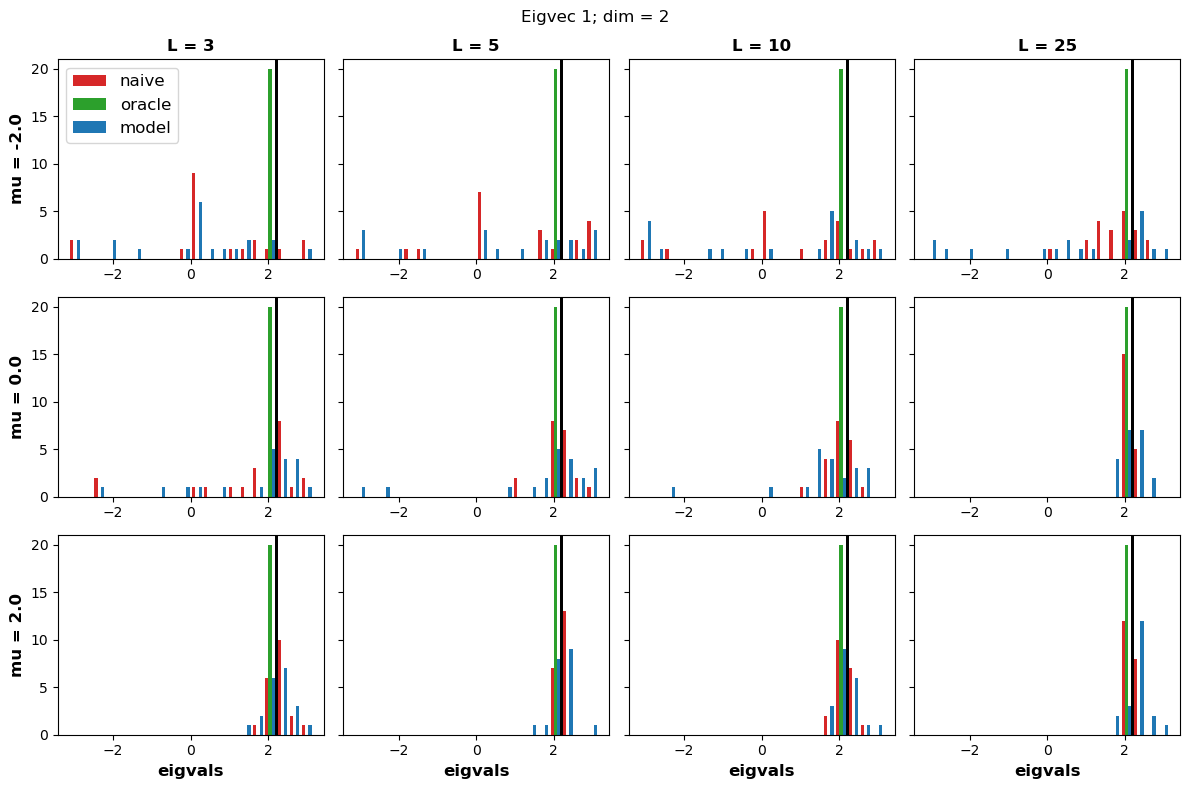

In [29]:
mus = jnp.array([-2.0, 0.0, 2.0])
Ls = jnp.array([3, 5, 10, 25])
# mus = jnp.array([-2.0, 0.0])
# Ls = jnp.array([3, 5])
dim = 1
fig, ax = plt.subplots(mus.size, Ls.size, figsize=(12,8), sharex=False, sharey=True)
for m, mu in enumerate(mus):
    for ell, L in enumerate(Ls):
        plot_eigvec_sim_model_hist(ax[m,ell], model_func, jnp.angle, dim, mu, L, init='empirical', num_samples=20)
        if m == 0 and ell == 0:
            ax[m,ell].legend(prop={'size': 12})
        if ell == 0:
            ax[m,ell].set_ylabel(f'mu = {mu}', fontweight='bold', fontsize=12)
        if m == 0:
            ax[m,ell].set_title(f'L = {L}', fontweight='bold', fontsize=12)
        if m == mus.size - 1:
            ax[m,ell].set_xlabel('eigvals', fontweight='bold', fontsize=12)
fig.suptitle(f'Eigvec 1; dim = {dim+1}')
plt.tight_layout()

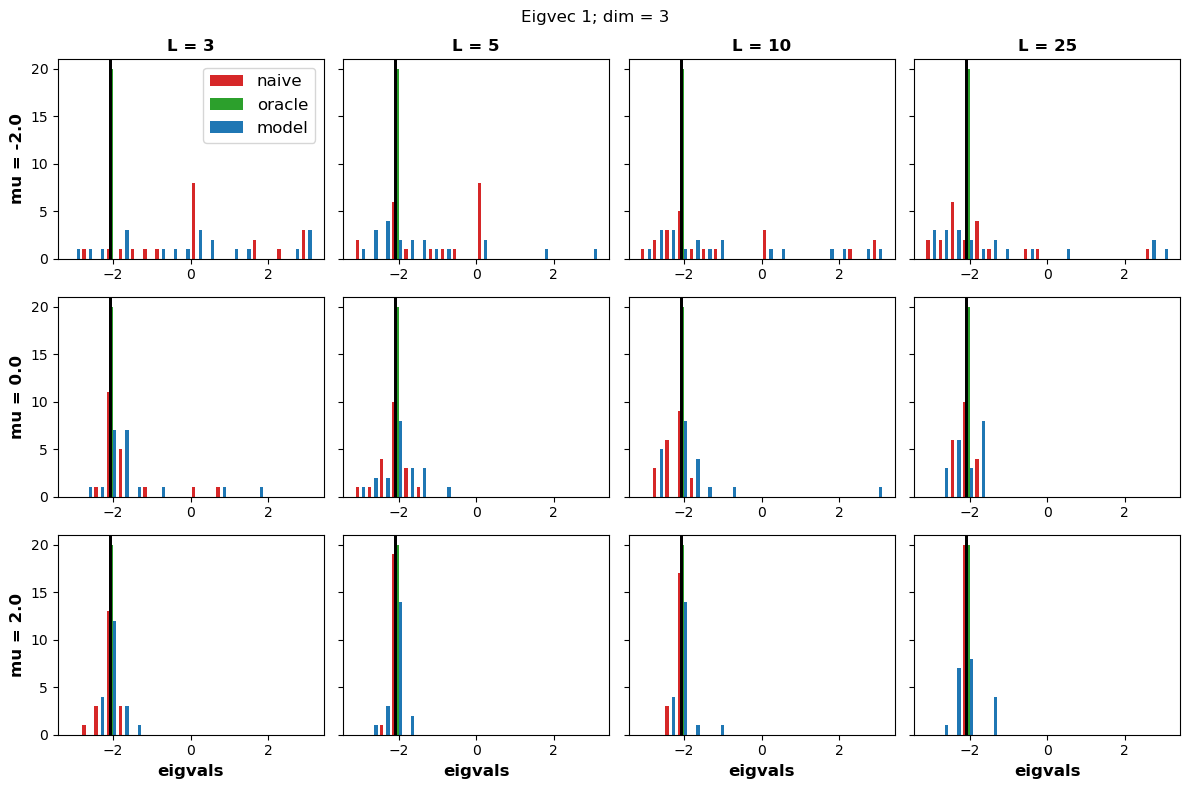

In [30]:
mus = jnp.array([-2.0, 0.0, 2.0])
Ls = jnp.array([3, 5, 10, 25])
# mus = jnp.array([-2.0, 0.0])
# Ls = jnp.array([3, 5])
dim = 2
fig, ax = plt.subplots(mus.size, Ls.size, figsize=(12,8), sharex=False, sharey=True)
for m, mu in enumerate(mus):
    for ell, L in enumerate(Ls):
        plot_eigvec_sim_model_hist(ax[m,ell], model_func, jnp.angle, dim, mu, L, init='empirical', num_samples=20)
        if m == 0 and ell == 0:
            ax[m,ell].legend(prop={'size': 12})
        if ell == 0:
            ax[m,ell].set_ylabel(f'mu = {mu}', fontweight='bold', fontsize=12)
        if m == 0:
            ax[m,ell].set_title(f'L = {L}', fontweight='bold', fontsize=12)
        if m == mus.size - 1:
            ax[m,ell].set_xlabel('eigvals', fontweight='bold', fontsize=12)
fig.suptitle(f'Eigvec 1; dim = {dim+1}')
plt.tight_layout()

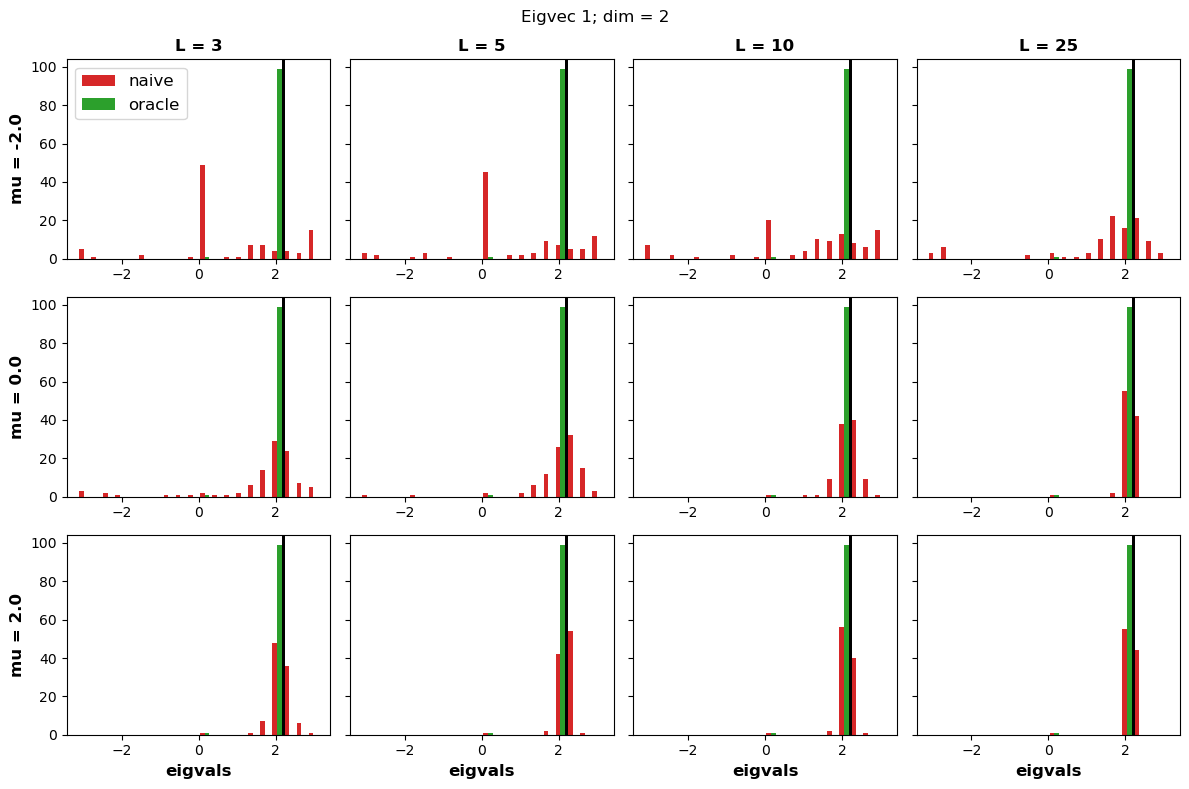

In [36]:
mus = jnp.array([-2.0, 0.0, 2.0])
Ls = jnp.array([3, 5, 10, 25])
# mus = jnp.array([-2.0, 0.0])
# Ls = jnp.array([3, 5])
dim = 1
fig, ax = plt.subplots(mus.size, Ls.size, figsize=(12,8), sharex=False, sharey=True)
for m, mu in enumerate(mus):
    for ell, L in enumerate(Ls):
        plot_eigvec_sim_hist(ax[m,ell], jnp.angle, dim, mu, L, num_samples=100)
        if m == 0 and ell == 0:
            ax[m,ell].legend(prop={'size': 12})
        if ell == 0:
            ax[m,ell].set_ylabel(f'mu = {mu}', fontweight='bold', fontsize=12)
        if m == 0:
            ax[m,ell].set_title(f'L = {L}', fontweight='bold', fontsize=12)
        if m == mus.size - 1:
            ax[m,ell].set_xlabel('eigvals', fontweight='bold', fontsize=12)
fig.suptitle(f'Eigvec 1; dim = {dim+1}')
plt.tight_layout()

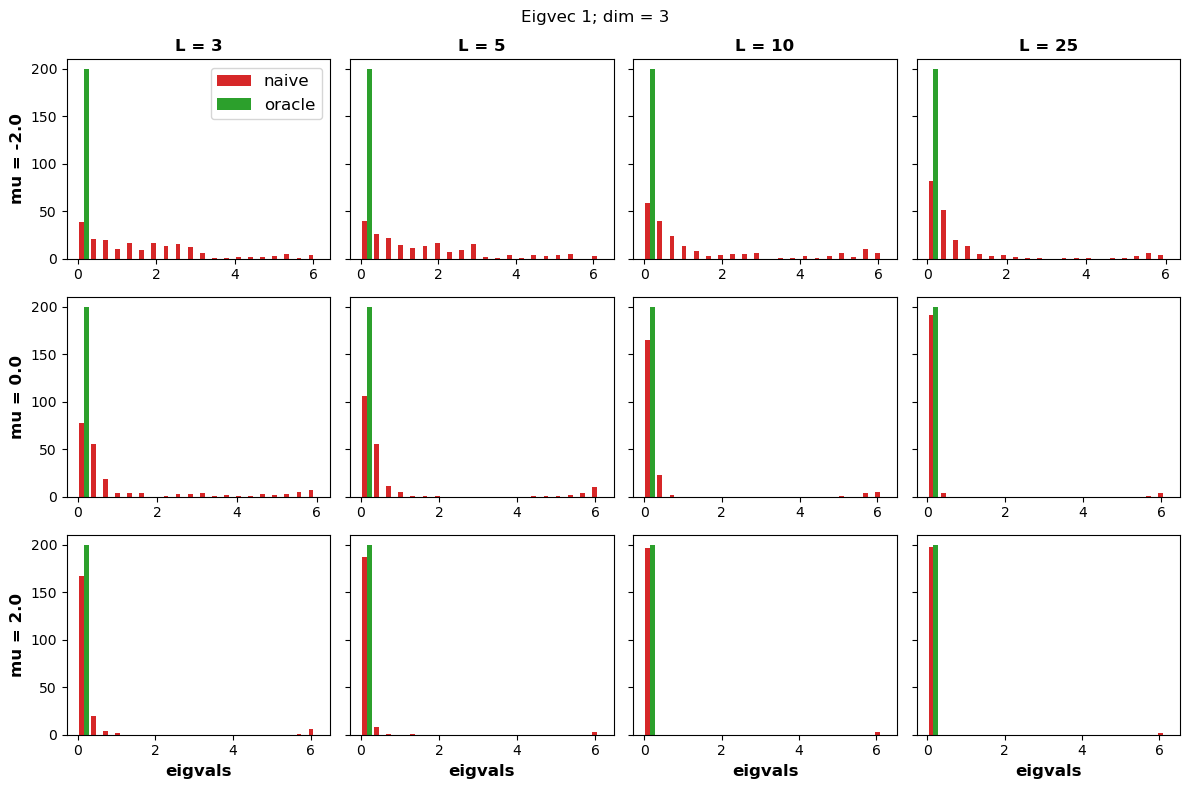

In [96]:
mus = jnp.array([-2.0, 0.0, 2.0])
Ls = jnp.array([3, 5, 10, 25])
# mus = jnp.array([-2.0, 0.0])
# Ls = jnp.array([3, 5])
dim = 2
fig, ax = plt.subplots(mus.size, Ls.size, figsize=(12,8), sharex=False, sharey=True)
for m, mu in enumerate(mus):
    for ell, L in enumerate(Ls):
        plot_eigvec_sim_hist(ax[m,ell], jnp.angle, dim, mu, L, num_samples=200)
        if m == 0 and ell == 0:
            ax[m,ell].legend(prop={'size': 12})
        if ell == 0:
            ax[m,ell].set_ylabel(f'mu = {mu}', fontweight='bold', fontsize=12)
        if m == 0:
            ax[m,ell].set_title(f'L = {L}', fontweight='bold', fontsize=12)
        if m == mus.size - 1:
            ax[m,ell].set_xlabel('eigvals', fontweight='bold', fontsize=12)
fig.suptitle(f'Eigvec 1; dim = {dim+1}')
plt.tight_layout()

In [18]:
lrccn_true.eigvecs.shape

(1, 3, 1)

In [19]:
eigvecs_naive.shape

(1, 3, 3)

In [7]:
test = get_sim_ests(3, 10, 1, 0.0)

In [8]:
test

{'lcfg': {'latent_type': 'basic_single_log',
  'K': 3,
  'rank': 1,
  'num_freqs': 500,
  'target_freq_ind': 9,
  'scale_power_target': 1000000.0,
  'L': 10,
  'seed': 1},
 'zs_nz': Array([[[  362.26822   -235.62419j ,  -539.15607   +902.07904j ,
            335.76718    +73.1075j  , -1022.34      -193.43161j ,
             -9.1434765 +246.87503j ,   -13.2654915 -233.41856j ,
            681.0582    -875.6936j  ,  -920.52734    +60.013958j,
            657.00446    +64.466606j,   196.70453   +474.23578j ],
         [ -352.357     -250.20302j ,  1037.1538    +169.55151j ,
            -55.521164  -339.11896j ,   196.17085  +1021.8178j  ,
            232.93108    -82.30427j ,  -212.17538    +98.192635j,
          -1064.8132    -311.21085j ,   394.3994    +833.9192j  ,
           -181.7153    -634.6576j  ,   368.6367    -357.35022j ],
         [   56.86154   +428.3968j  ,  -582.3992    -874.784j   ,
           -210.44145   +271.65915j ,   614.42114   -839.69135j ,
           -218.92978   -

In [4]:
# L = 10 
# ov2 = -1.0
K = 3
L = 10
seed = 1
mu = -1.0
init = 'empirical'
# res_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log/window1000/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/model-simple_inherit_latent_eigh/inherit-True/m_step-low-rank-eigh/{init}-init_eigvals-oracle_eigvecs-fit/newton-10_em-20/res.pkl'
if init == 'flat':
    res_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log/window1000/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/model-simple_inherit_latent_fullrank/inherit-True/m_step-full-rank-standard/{init}-init_6.0/newton-10_em-20/res.pkl'
if init == 'empirical':
    res_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log/window1000/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/model-simple_inherit_latent_fullrank/inherit-True/m_step-full-rank-standard/{init}-init/newton-10_em-20/res.pkl'
obs_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log/window1000/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/obs_sim.pkl'
latent_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log/window1000/K{K}/L{L}/lseed{seed}/latent_sim.pkl'

# latent_load = pickle_open(latent_path)
# obs_load = pickle_open(obs_path)
res_load = pickle_open(res_path)
obs_load = pickle_open(obs_path)
latent_load = pickle_open(latent_path)

obs = obs_load['obs']
zs_nz = latent_load['zs_nz']
cfg = omega(res_load['cfg'])
lcfg = cfg.latent
nz_model = jnp.array([lcfg.target_freq_ind])

In [5]:
latent_load.keys()

dict_keys(['lcfg', 'zs_nz', 'nz', 'freqs'])

In [6]:
latent_load['lcfg']

{'latent_type': 'basic_single_log',
 'K': 3,
 'rank': 1,
 'num_freqs': 500,
 'target_freq_ind': 9,
 'scale_power_target': 1000000.0,
 'L': 10,
 'seed': 1}

In [7]:
from cohlib.jax.lr_model import rotate_eigvecs
from cohlib.jax.dists import naive_estimator
import cohlib.confs.utils as conf
lcfg = conf.omega(latent_load['lcfg'])
lrccn_true = conf.create_lrccn_basic_rank1(lcfg)
gamma_true = lrccn_true.get_gamma()

In [8]:
eigvals, eigvecs = jnp.linalg.eigh(res_load['track']['ccn'][0].gamma)
print(eigvecs[0,:,-1])
print(rotate_eigvecs(eigvecs)[0,:,-1])

[-0.17228527+0.j          0.5376045 +0.8209299j   0.02410889-0.08241445j]
[ 0.17228527-1.5061657e-08j -0.5376046 -8.2092983e-01j
 -0.02410888+8.2414448e-02j]


In [9]:
naive_est = naive_estimator(obs, nz_model)*1e6
eigvals_naive_raw, eigvecs_naive_raw = jnp.linalg.eigh(naive_est)
eigvals_naive = eigvals_naive_raw[:,::-1]
eigvecs_naive = eigvecs_naive_raw[:,:,::-1]

oracle_est = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
eigvals_oracle_raw, eigvecs_oracle_raw = jnp.linalg.eigh(oracle_est)
eigvals_oracle = eigvals_oracle_raw[:,::-1]
eigvecs_oracle = eigvecs_oracle_raw[:,:,::-1]


In [10]:
print(eigvecs_naive[0,:,0])
print(rotate_eigvecs(eigvecs_naive)[0,:,0])
print(jnp.angle(rotate_eigvecs(eigvecs_naive)[0,:,0]))

[-0.17228527+0.j          0.5376045 +0.8209299j   0.02410889-0.08241445j]
[ 0.17228527-1.5061657e-08j -0.5376046 -8.2092983e-01j
 -0.02410888+8.2414448e-02j]
[-8.7422777e-08 -2.1505895e+00  1.8553879e+00]


In [11]:
print(eigvecs_oracle[0,:,0])
print(rotate_eigvecs(eigvecs_oracle)[0,:,0])
print(jnp.angle(rotate_eigvecs(eigvecs_oracle)[0,:,0]))

[ 0.5773504 +0.j         -0.2123636 -0.53687507j -0.24837185+0.52119535j]
[ 0.5773504 +0.j         -0.2123636 -0.53687507j -0.24837185+0.52119535j]
[ 0.        -1.947465   2.0155025]


In [12]:
def get_eigvecs(ccn):
    """
    ccn.gamma shape (J x K x K)
    """
    gamma = ccn.gamma
    _, eigvecs_raw = jnp.linalg.eigh(gamma)
    eigvecs = eigvecs_raw[:,:,::-1]
    return eigvecs

for r in range(5):
    ccn_r = res_load['track']['ccn'][r]
    eigvecs_em_r = get_eigvecs(ccn_r)
    angles = jnp.angle(rotate_eigvecs(eigvecs_em_r)[0,:,0])
    gamma = ccn_r.get_gamma()
    print(jnp.round(gamma,-2))

    print('')
    print(jnp.round(rotate_eigvecs(eigvecs_em_r)[0,:,0],4))
    print(jnp.round(angles,4))
    # gamma = lrccn_r.get_gamma_pinv()
    # print(jnp.round(gamma,9))
    # print(gamma)
    print('')




[[[ 500000.     -0.j  -79300.+132400.j  -12200.-293300.j]
  [ -79300.-132400.j 1491200.     -0.j   -4700. +24600.j]
  [ -12200.+293300.j   -4700. -24600.j  699600.     -0.j]]]

[ 0.1723-0.j         -0.5376-0.82089996j -0.0241+0.0824j    ]
[-0.     -2.1506  1.8554]

[[[ 539800.  +1600.j  -97700.+164100.j  -16400.-354400.j]
  [ -99900.-162800.j 1526700. -18800.j  -25300. +45200.j]
  [ -14500.+354600.j  -25600. -45700.j  757500.  -5400.j]]]

[ 0.2287-0.j     -0.5361-0.7974j -0.0317+0.1528j]
[-0.        -2.1627     1.7753999]

[[[ 579400.  +1800.j -115400.+192300.j  -20100.-413300.j]
  [-117900.-190700.j 1542800. -18500.j  -45900. +65500.j]
  [ -17500.+413500.j  -46600. -65700.j  810600.  -6600.j]]]

[ 0.2886-0.j     -0.5259-0.7653j -0.0381+0.2302j]
[-0.     -2.1729  1.7349]

[[[ 615900.  +1900.j -131100.+216800.j  -23500.-466500.j]
  [-133700.-215100.j 1549100. -18100.j  -64600. +83800.j]
  [ -20200.+466700.j  -65700. -83800.j  855700.  -7600.j]]]

[ 0.3436-0.j     -0.5083-0.7281j -0.0428

In [13]:
# look at eigenvector * root eigenvalue 